# Homework 2:

### Deadline: Thursday 28 November 2024 (by 19h00)
### Credits: 20 points

## Name/s: Vincent Noguera

### Instructions:

- When you finish, please send me the **.ipynb** file via email to wbanda@yachaytech.edu.ec


- This homework can be submitted **individually or in pairs**. Please include your name/s in the notebook.


- Within a **single python notebook**, solve the following problem:

# Shocks in subsonic and supersonic turbulence

We want to study the properties of subsonic and supersonic turbulent flows in 2D. Shock waves are flow discontinuities that arise in turbulent gases when the local flow speed exceeds the sound speed of the gas. Let us consider the following high-resolution simulations of turbulence-in-a-box models:

### Supersonic turbulence simulation:
https://yachaytecheduec-my.sharepoint.com/:f:/g/personal/wbanda_yachaytech_edu_ec/EhXQXyn8GudCnZ15af_fLdEBcbpt7hyYpjSnwsGHrG0kDA?e=IlgN7g

### Subsonic turbulence simulation:
https://yachaytecheduec-my.sharepoint.com/:f:/g/personal/wbanda_yachaytech_edu_ec/EhNeXlEHX3JAjUYV44981LgBo9tn_BEFtUQJx98iGClHxg?e=350N8b

As explained in class, these simulations introduce stochastic force fields to generate turbulent motions in an isothermal ($\gamma=1$) gas, which is initially at rest. Turbulence is continuously generated throughout the simulations.

The simulation folders contain 101 VTK files, jointly with:

- a **units.out** file that contains the CGS normalisation values and the isothermal sound speed ($c_{\rm iso}$).

- a **vtk.out** file whose second column contains the times in code units.

Each VTK file stores the following fields:

- density (rho)

- velocity_x (vx1)

- velocity_y (vx2)

- magnetic_field_x (Bx1)

- magnetic_field_y (Bx2)

Remember that you can use VisIt to inspect the data and check if your code produces consistent outputs.



# Import libraries

In [1]:
#Python version used 3.9
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
import pandas as pd
import scienceplots
import os
import scipy.constants as cte
import glob
from PIL import Image
from IPython import display
from skimage.transform import resize
import scipy.optimize as opt
from pyevtk.hl import gridToVTK

## 1. (3 points) Data I/O functions:

Create a set of Python functions that:

(a) reads the **units.out** file, and returns the normalisation values for length, velocity, density, magnetic field, time, and isothermal sound speed ($c_{\rm iso}$) into callable objects.

**Note:**
The normalisation values for the magnetic field ($B_0=\sqrt{4\,\pi\,\rho_0\,v_0^2}$), and time ($t_0=\frac{L_0}{v_0}$) can be derived from the length, velocity, and density values.

(b) opens any **VTK** file, reads the data arrays, and returns the 2D, CGS-normalised arrays for:

- density (rho)

- velocity_x (vx1)

- velocity_y (vx2)

- magnetic_field_x (Bx1)

- magnetic_field_y (Bx2)

**Note:**
Use the normalisation values returned by the function from part **(a)** to convert from code units to CGS units.

(c) reads the 2D arrays returned by the function above, interpolates them into a CGS-normalised meshgrid created with the mesh information stored in the VTK files, and exports 3 figures containing maps of:

- density

- velocity vector field, scaled by its magnitude, $v=\sqrt{v_x^2+v_y^2}$.

- magnetic vector field, scaled by its magnitude: $B=\sqrt{B_x^2+B_y^2}$.

**Notes:**

- Choose different perceptually-uniform colour schemes for each of the above quantities.
  
- Since these are high-resolution models, one way to improve the visualisation of 2D vector fields is to rescale them onto a coarser grid.




In [2]:
def IO_units_out(path):
    """
    Reads normalization values for density, velocity, and length from 'units.out'
    and calculates additional normalization constants for thermal pressure, 
    magnetic field, and time.

    Parameters:
        path (str): Path to the directory containing the file 'units.out'.

    Returns:
        tuple: 
            - nrho_0 (numpy.ndarray): Normalization value for density.
            - nl_0 (numpy.ndarray): Normalization value for length.
            - nv_0 (numpy.ndarray): Normalization value for velocity.
            - c_iso_0 (numpy.ndarray): Normalization value for isothermal sound speed.
            - nB_0 (numpy.ndarray): Calculated normalization value for magnetic field.
            - nt_0 (numpy.ndarray): Calculated normalization value for time.

    Assumptions:
        - The file 'units.out' is a CSV-like file with columns named 'variable' 
          and 'normalisation'.
        - The variables 'rho_0', 'v_0', 'L_0', and 'c_iso' are present in the file.
    
    Notes:
        - `nB_0` is computed using the formula for magnetic field normalization:
          \( B_0 = \sqrt{4\pi \rho_0 v_0^2} \)
        - `nt_0` is computed as \( t_0 = \frac{L_0}{v_0} \).
    """
    # Read the file 'units.out' into a DataFrame
    df_units = pd.read_csv(path + "units.out")
    
    # Extract normalization values from the DataFrame
    nrho_0 = np.array(df_units.loc[df_units["variable"] == "rho_0", "normalisation"])
    nv_0 = np.array(df_units.loc[df_units["variable"] == "v_0", "normalisation"])
    nl_0 = np.array(df_units.loc[df_units["variable"] == "L_0", "normalisation"])
    c_iso_0 = np.array(df_units.loc[df_units["variable"] == "c_iso", "normalisation"])
    
    # Calculate additional normalization values
    nB_0 = np.sqrt(4 * np.pi * nrho_0 * (nv_0 ** 2))  # Magnetic field normalization
    nt_0 = nl_0 / nv_0  # Time normalization
    
    # Return the normalization constants as a tuple
    return nrho_0, nl_0, nv_0, c_iso_0, nB_0, nt_0


In [3]:
def IO_vtk_out(fname, t0):
    """
    Reads time values from 'vtk.out' file and converts the time to CGS units.

    Parameters:
        fname (str): Path to the directory containing the 'vtk.out' file.
        t0 (float): Time normalization factor to convert code time units to CGS units.

    Returns:
        numpy.ndarray: Array of time values in CGS units.

    Notes:
        - The 'vtk.out' file is assumed to be space-separated with no header row.
        - The time is assumed to be in the second column (index 1) of the file.
    """
    # Read the 'vtk.out' file into a DataFrame, assuming space-separated values
    df_vtk_out = pd.read_csv(fname + "vtk.out", sep=r"\s+", header=None)

    # Extract time values from the second column (index 1) of the DataFrame
    t_cu = np.array(df_vtk_out.loc[:, 1])

    # Convert time values from code units (t_cu) to CGS units using the provided factor (t0)
    t_cgs = t_cu * t0

    return t_cgs


In [4]:
def read_VTK(path, constants):
    """
    Reads and converts data from a VTK file to CGS units and reshapes the data into 2D arrays.

    Parameters:
        path (str): Path to the VTK file to be read.
        constants (tuple): A tuple containing the following constants needed for conversion:
            - nrho_0 (float): Normalization value for density.
            - nl_0 (float): Normalization value for length.
            - nv_0 (float): Normalization value for velocity.
            - c_iso_0 (float): Isothermal sound speed
            - nB_0 (float): Normalization value for magnetic field.
            - nt_0 (float): Normalization value for time.
            
    Returns:
        tuple: 
            - mesh_from_vtk: The VTK mesh object.
            - cgs_values: A list containing the CGS values for:
                [ rho_cgs, vx1_cgs, vx2_cgs, Bx1_cgs, Bx2_cgs, prs_cgs]
            - cgs_values_2D: A list containing the CGS values reshaped into 2D arrays:
                [rho_cgs2D, vx1_cgs2D, vx2_cgs2D, Bx1_cgs2D, Bx2_cgs2D]

    Notes:
        - This function assumes the mesh has two dimensions and that data for density, velocity, magnetic field, and pressure are stored as cell data.
    """
    
    # Unpack constants
    nrho_0, nl_0, nv_0, c_iso_0, nB_0, nt_0 = constants

    # Read the VTK mesh file
    mesh_from_vtk = pv.read(path)

    # Extract relevant data arrays from the mesh
    rho = pv.get_array(mesh_from_vtk, "rho", preference='cell')
    vx1 = pv.get_array(mesh_from_vtk, "vx1", preference='cell')
    vx2 = pv.get_array(mesh_from_vtk, "vx2", preference='cell')
    Bx1 = pv.get_array(mesh_from_vtk, "Bx1", preference='cell')
    Bx2 = pv.get_array(mesh_from_vtk, "Bx2", preference='cell')
    prs = pv.get_array(mesh_from_vtk, "prs", preference='cell')

    # Convert data to CGS units using the provided normalization constants
    rho_cgs = rho * nrho_0
    vx1_cgs = vx1 * nv_0
    vx2_cgs = vx2 * nv_0
    Bx1_cgs = Bx1 * nB_0
    Bx2_cgs = Bx2 * nB_0
    prs_cgs = prs  # Assuming pressure is already in CGS units or it will be calculated later

    # Reshape arrays into 2D (subtracting 1 because the VTK mesh may have one more dimension)
    rho_cgs2D = rho_cgs.reshape(mesh_from_vtk.dimensions[0] - 1, mesh_from_vtk.dimensions[1] - 1)
    vx1_cgs2D = vx1_cgs.reshape(mesh_from_vtk.dimensions[0] - 1, mesh_from_vtk.dimensions[1] - 1)
    vx2_cgs2D = vx2_cgs.reshape(mesh_from_vtk.dimensions[0] - 1, mesh_from_vtk.dimensions[1] - 1)
    Bx1_cgs2D = Bx1_cgs.reshape(mesh_from_vtk.dimensions[0] - 1, mesh_from_vtk.dimensions[1] - 1)
    Bx2_cgs2D = Bx2_cgs.reshape(mesh_from_vtk.dimensions[0] - 1, mesh_from_vtk.dimensions[1] - 1)

    # Return the calculated CGS values and the mesh
    cgs_values = [rho_cgs, vx1_cgs, vx2_cgs, Bx1_cgs, Bx2_cgs, prs_cgs]
    cgs_values_2D = [rho_cgs2D, vx1_cgs2D, vx2_cgs2D, Bx1_cgs2D, Bx2_cgs2D]

    return mesh_from_vtk, cgs_values, cgs_values_2D


In [5]:
def generate_and_interpolate(mesh_from_vtk, cgs_values_2D, nl_0, B_shape_2D_resize, V_shape_2D_resize):
    """
    Generates coordinate vectors and grids, and interpolates physical quantities to a target resolution.

    Parameters:
    - mesh_from_vtk: Object
        Contains grid bounds and dimensions.
    - cgs_values_2D: tuple
        Contains 2D arrays for physical quantities (density, velocity, magnetic field components).
    - nl_0: float
        Normalization length for scaling coordinates.
    - B_shape_2D_resize: int
        Target size for magnetic field grid.
    - V_shape_2D_resize: int
        Target size for velocity grid.

    Returns:
    - interpolated_data: list
        Interpolated fields (density, magnetic field) and coordinate grids.
    """
    # Generate general grid
    x = np.linspace(mesh_from_vtk.bounds[0], mesh_from_vtk.bounds[1], mesh_from_vtk.dimensions[1] - 1) * nl_0
    y = np.linspace(mesh_from_vtk.bounds[2], mesh_from_vtk.bounds[3], mesh_from_vtk.dimensions[0] - 1) * nl_0
    x_2d, y_2d = np.meshgrid(x, y)

    # Generate resized grid for the velocity field
    x_v = np.linspace(mesh_from_vtk.bounds[0], mesh_from_vtk.bounds[1], V_shape_2D_resize) * nl_0
    y_v = np.linspace(mesh_from_vtk.bounds[2], mesh_from_vtk.bounds[3], V_shape_2D_resize) * nl_0
    x_2d_v, y_2d_v = np.meshgrid(x_v, y_v)
    
    # Generate resized grid for the magnetic field
    x_b = np.linspace(mesh_from_vtk.bounds[0], mesh_from_vtk.bounds[1], B_shape_2D_resize) * nl_0
    y_b = np.linspace(mesh_from_vtk.bounds[2], mesh_from_vtk.bounds[3], B_shape_2D_resize) * nl_0
    x_2d_b, y_2d_b = np.meshgrid(x_b, y_b)

    # Interpolate physical variables
    rho_cgs2D, vx1_cgs2D, vx2_cgs2D, Bx1_cgs2D, Bx2_cgs2D = cgs_values_2D

    # Resize magnetic field arrays
    Bx1_cgs2D_resized = resize(Bx1_cgs2D, (B_shape_2D_resize, B_shape_2D_resize), preserve_range=True, anti_aliasing=True)
    Bx2_cgs2D_resized = resize(Bx2_cgs2D, (B_shape_2D_resize, B_shape_2D_resize), preserve_range=True, anti_aliasing=True)

    # Resize velocity field arrays
    vx1_cgs2D_resized = resize(vx1_cgs2D, (V_shape_2D_resize, V_shape_2D_resize), preserve_range=True, anti_aliasing=True)
    vx2_cgs2D_resized = resize(vx2_cgs2D, (V_shape_2D_resize, V_shape_2D_resize), preserve_range=True, anti_aliasing=True)

    resized_field = [Bx1_cgs2D_resized, Bx2_cgs2D_resized, vx1_cgs2D_resized, vx2_cgs2D_resized]
    coord_vect = [x, y]
    grid = [x_2d, y_2d]
    velocity_grid = [x_2d_v, y_2d_v]
    magnetic_grid = [x_2d_b, y_2d_b]
    interpolated_data = [cgs_values_2D, resized_field, coord_vect, grid, magnetic_grid, velocity_grid]

    return interpolated_data


def plot_for_interpolated(interpolated_data, directory_name, type_img, i):
    """
    Plots and saves visualizations of the physical fields (density, velocity, magnetic field) 
    based on the provided interpolated data, and saves them to the specified directory.

    Parameters:
    - interpolated_data: list
        Contains interpolated physical fields (density, magnetic field, velocity) and grids.
    - directory_name: str
        The directory where the plot images will be saved.
    - type_img: str
        The type of image to help in naming the plot files (e.g., 'type1').
    - i: int
        An integer to uniquely identify each plot image (used in the file name).
    
    Returns:
    - file_list: list
        List of filenames for the generated plot images.
    """
    # Extract interpolated data
    cgs_values_2D, resized_field, coord_vect, grid, magnetic_grid, velocity_grid = interpolated_data

    # Get the original magnetic and velocity fields
    rho_cgs2D, vx1_cgs2D, vx2_cgs2D, Bx1_cgs2D, Bx2_cgs2D = cgs_values_2D

    # Calculate the magnitudes
    # b_2d = np.sqrt(Bx1_cgs2D*2 + Bx2_cgs2D*2)
    # v_2d = np.sqrt(vx1_cgs2D*2 + vx2_cgs2D*2)
    
    b_2d = np.sqrt(Bx1_cgs2D**2 + Bx2_cgs2D**2)
    v_2d = np.sqrt(vx1_cgs2D**2 + vx2_cgs2D**2)

    # Calculate magnitudes
    mag_B_resized = np.sqrt(resized_field[0]*2 + resized_field[1]*2)
    vel_2d = np.sqrt(resized_field[2]*2 + resized_field[3]*2)

    # Create the directory
    try:
        os.makedirs(directory_name, exist_ok=True)  # Improved directory creation
        print(f"Directory '{directory_name}' created or already exists.")
    except Exception as e:
        print(f"An error occurred: {e}")

    file_list = []

    # Plotting the density
    plt.figure(figsize=(6, 4))
    plt.title("Gas Density in Log Scale")
    plt.xlabel('X (cm)')
    plt.ylabel('Y (cm)')
    z_dens = plt.pcolormesh(grid[0], grid[1], np.log(cgs_values_2D[0]), cmap="Blues")
    cb = plt.colorbar(z_dens, shrink=0.8)
    cb.set_label(r"Density ln[g cm$^{-3}$]")
    plt.gca().set_aspect('equal')
    plt.savefig(f"{directory_name}/{type_img}density_field{i:04d}.png", dpi=150)
    file_list.append(f"{type_img}density_field{i:04d}.png")
    plt.close()

    # Plotting the velocity vector field
    plt.figure(figsize=(6, 4))
    plt.title("Velocity Vector Field")
    plt.xlabel("X (cm)")
    plt.ylabel("Y (cm)")
    plt.pcolormesh(grid[0], grid[1], v_2d, cmap="magma")
    plt.quiver(velocity_grid[0], velocity_grid[1], resized_field[2], resized_field[3], vel_2d, cmap="Greys")
    plt.colorbar(label=r"Velocity [cm s$^{-1}$]")
    plt.gca().set_aspect("equal")
    plt.savefig(f"{directory_name}/{type_img}velocity_vector_field{i:04d}.png", dpi=150)
    file_list.append(f"{type_img}velocity_vector_field{i:04d}.png")
    plt.close()

    # Plotting the magnetic field intensity with vector field
    plt.figure(figsize=(6, 4))
    plt.title("Magnetic Field Intensity")
    plt.xlabel('X (cm)')
    plt.ylabel('Y (cm)')
    z_magnetic = plt.pcolormesh(grid[0], grid[1], b_2d, cmap="inferno_r")
    cb = plt.colorbar(z_magnetic, shrink=0.8)
    cb.set_label(r"Magnetic Field [G]")
    z = plt.quiver(magnetic_grid[0], magnetic_grid[1], resized_field[0], resized_field[1], mag_B_resized, cmap='Greys_r')
    cb2 = plt.colorbar(z, shrink=0.8)
    cb2.set_label(r"B lines")
    plt.gca().set_aspect('equal')
    plt.savefig(f"{directory_name}/{type_img}magnetic_field_intensity{i:04d}.png", dpi=150)
    file_list.append(f"{type_img}magnetic_field_intensity{i:04d}.png")
    plt.close()

    return file_list

In [6]:
# fname="/home/klaus/CP1/MT/Orszag_Tang-MHD/"
# # Read units.out file

# df_units = pv.read(fname + "data.0000.vtk")

# print(df_units.array_names)
# # # df_units = pd.read_csv(fname + "units.out")

# # df_vtk_out = pd.read_csv(fname + "vtk.out", sep = "\s+", header = None)

# # print(df_units)

## 2. (4 points) Data visualisation and density comparison:

Use python to carry out the following analysis:

(d) Call the above functions for VTK file # 50 of each simulation, and make the following maps using the correct mesh coordinates and dimensions:

- A 2-panel figure showing the supersonic (left) and subsonic (right) density, $\rho$.

- A 2-panel figure showing the supersonic (left) and subsonic (right) velocity vector field, $\vec{v}$.

- A 2-panel figure showing the supersonic (left) and subsonic (right) magnetic vector field, $\vec{B}$.

(e) Compute 1D histograms of the density and the velocity magnitude, and make the following figures:

- A 2-panel figure showing the supersonic (left) and subsonic (right) 1D histograms of the density.

- A 2-panel figure showing the supersonic (left) and subsonic (right) 1D histograms of the velocity magnitude.

(f) What distributions do the density and velocity fields have? Do you see differences between the supersonic and subsonic distributions? Why?



In [7]:
def create_2_panel_figure(folder, supersonic_file, subsonic_file, save_name, title_left, title_right, show):
    """
    Create a 2-panel figure by displaying two saved images side by side.

    This function loads two image files (supersonic and subsonic plots), arranges them in a 
    two-panel figure, and saves the combined image. It is useful for comparing two different 
    plots visually in a single figure.

    Parameters:
    - folder: str
        Directory where the image files are stored.
    - supersonic_file: str
        Path to the image file representing the supersonic plot.
    - subsonic_file: str
        Path to the image file representing the subsonic plot.
    - save_name: str
        Path where the combined figure will be saved.
    - title_left: str
        Title to display for the left panel (supersonic plot).
    - title_right: str
        Title to display for the right panel (subsonic plot).
    """
    # Create a figure with 2 subplots arranged horizontally
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Load the images from the provided file paths
    img_supersonic = Image.open(folder+"/"+supersonic_file)
    img_subsonic = Image.open(folder+"/"+subsonic_file)

    # Plot the supersonic image in the left panel
    axes[0].imshow(img_supersonic)
    axes[0].axis('off')  # Hide axis ticks and labels
    axes[0].set_title(title_left)  # Set the left panel title

    # Plot the subsonic image in the right panel
    axes[1].imshow(img_subsonic)
    axes[1].axis('off')  # Hide axis ticks and labels
    axes[1].set_title(title_right)  # Set the right panel title

    # Adjust layout to avoid overlap and save the final figure
    plt.tight_layout()
    plt.savefig(folder+"/"+save_name, dpi=150)
    if show == True:
        plt.show()  # Display the combined figure
    plt.close()
def generate_titles(file_list):
    """
    Generates titles by replacing underscores with spaces in each filename.

    Args:
        file_list (list): List of filenames.

    Returns:
        title_list: A list of titles with underscores replaced by spaces.
    """
    title_list=[]
    for i in file_list:
        to_add = i.replace("_", " ")
        title_list.append(to_add)
    return title_list


In [8]:
def histograms(cgs_values, num, type_img, directory_name, t_cgs):
    """
    Generate and save histograms for density and velocity magnitude from the provided data.

    This function takes data for density and velocity components, generates two histograms (one for 
    density and one for velocity magnitude), and saves them as PNG images in the specified directory. 
    It returns a list of the saved image filenames.

    Parameters:
    - cgs_values: list of arrays
        A list containing the following arrays in CGS units:
        [density (rho_cgs), velocity components (vx1_cgs, vx2_cgs), magnetic field components (Bx1_cgs, Bx2_cgs)].
    - num: int
        An index representing the specific time step or iteration for labeling the plot.
    - type_img: str
        A string used to define the type of image for naming the output files (e.g., "simulation", "snapshot").
    - directory_name: str
        The directory where the histogram images will be saved.

    Returns:
    - file_list: list of str
        A list of filenames for the saved histogram images.
    """
    
    # Unpack the CGS values from the input list
    rho_cgs, vx1_cgs, vx2_cgs, Bx1_cgs, Bx2_cgs, prs_cgs = cgs_values
    i = num  # Set the current index for naming files
    file_list = []  # Initialize a list to keep track of the saved files

    # Create histogram for the density data
    with plt.style.context(['science', 'notebook', 'no-latex']):
        plt.figure(figsize=(6, 4))
        
        # Plot density histogram
        n, bins, patches = plt.hist(rho_cgs, bins='auto', density=True, color="darkorange", alpha=0.7, edgecolor="black")
        plt.title(f"Density Histogram at t = {t_cgs[i]:.4e}")
        plt.xlabel(r"Density [$g/cm^3$]", fontsize=12)
        plt.ylabel(r"N")
        plt.grid(alpha=0.3, linestyle="--")
        plt.xlim(0, 8e-24)
        plt.savefig(f"{directory_name}/{type_img}_histogram_density_{i:04d}.png", dpi=150)
        print(f"Saved density histogram at: {directory_name}/{type_img}_histogram_density_{i:04d}.png")

        # Append the filename to the list
        name = f"{type_img}_histogram_density_{i:04d}.png"
        file_list.append(name)
        plt.close()

    # Compute the velocity magnitude (1D) from the velocity components
    vel_mag_1d = np.sqrt(vx1_cgs**2 + vx2_cgs**2)

    # Create histogram for the velocity magnitude data
    with plt.style.context(['science', 'notebook', 'no-latex']):
        plt.figure(figsize=(6, 4))

        # Plot velocity histogram
        n, bins, patches = plt.hist(vel_mag_1d, bins='auto', density=True, color="steelblue", alpha=0.7, edgecolor="black")
        plt.title(f"Velocity Histogram at t = {t_cgs[i]:.4e}")
        plt.xlabel(r"Velocity Magnitude [$cm/s$]", fontsize=12)
        plt.ylabel(r"N")
        plt.grid(alpha=0.3, linestyle="--")
        plt.xlim(-0.1, 3e6)
        plt.tight_layout()
        plt.savefig(f"{directory_name}/{type_img}_velocity_histogram_{i:04d}.png", dpi=150)
        print(f"Saved velocity histogram at: {directory_name}/{type_img}_velocity_histogram_{i:04d}.png")

        # Append the filename to the list
        name = f"{type_img}_velocity_histogram_{i:04d}.png"
        file_list.append(name)
        plt.close()

    # Return the list of saved filenames
    return file_list



In [9]:

# Function to define a log-normal distribution
def log_normal(x, mu, s):
    """
    Log-normal distribution model.
    
    This function computes the probability density of a log-normal distribution for a given set of input values.
    The log-normal distribution is a continuous probability distribution of a random variable whose logarithm 
    is normally distributed.

    Parameters:
    - x: array-like
        Input data (x-axis values) for which the log-normal distribution is evaluated. The values should be positive.
    - mu: float
        The mean (μ) of the underlying normal distribution, which is the logarithm of the original distribution.
    - s: float
        The standard deviation (σ) of the underlying normal distribution.

    Returns:
    - y_model: array-like
        The evaluated log-normal values corresponding to the input `x`, calculated based on the given `mu` and `s`.
    """
    # Ensure x is positive
    # x = np.maximum(x, 1e-10)  # Prevent log(0) or log-negative errors
    y_model = (np.exp(-(np.log(x) - mu)**2 / (2 * s**2)) / (x * s * np.sqrt(2 * np.pi)))

    return y_model
    
def fit_and_plot_log_normal(density_data,title, label,xlabel,ylabel, color_1,color_2,norm_density, renorm_density):
    # Create histogram from the density data
    n, bins = np.histogram(density_data, bins='auto', density=True)
    
    # Shift arrays to get the centers of the bins
    x0 = 0.5 * (bins[1:] + bins[:-1])  # Centers of the bins

    # Renormalize axes (e.g., by a factor of 1.e24 or as required)
    x1 = x0 / norm_density # Example normalization for density
    n1 = n / renorm_density     # Renormalizing the histogram values
    
    # Fit the log-normal distribution
    try:
        coef, _ = opt.curve_fit(log_normal, x1, n1)  # Initial guess: mu=0, s=1
    except RuntimeError:
        print(f"Fitting failed for {label}")
        return
    
    # Evaluate the fitted log-normal model
    n_fit = log_normal(x1, coef[0], coef[1])

    # Plot the histogram and the fitted curve
    plt.plot(x1, n1, label=f"{label} - Renormalized Data", color=color_1, linestyle='-')
    plt.plot(x1, n_fit, label=f"{label} - Fit ($\mu$ = {coef[0]:.2f}, $\sigma$ = {coef[1]:.2f})", color=color_2, linestyle='--')
    plt.legend()
    plt.title(f"{title}")
    plt.xlabel(f"{xlabel}", fontsize=12)
    plt.ylabel(f"{ylabel}")
    plt.grid(alpha=0.3, linestyle="--")

#### Subsonic:

In [10]:
##Plot the Subsonic system:
#Here change the path for Subsonic folder
fname_sub="/home/klaus/CP1/Homeworks/HW2/TURB_DRIVE_SUB_hr/"

# define the folder that we will use:
directory_name = "output_data"
#Get the normalized constants 
constants_normalized=IO_units_out(fname_sub) #nrho_0, nl_0, nv_0, c_iso_0, nB_0, nt_0
#Get the t_cgs for name the histograms
t_cgs = IO_vtk_out(fname_sub,constants_normalized[5])


In [11]:
#Define the number of the file that are going to use:
num = 50
#Define the resize to get a visualization of the magnetic field:
B_shape_2D_resize=30
V_shape_2D_resize=30
path = f"{fname_sub}data.{num:04d}.vtk"

#Get the data of the VTK file
mesh_from_vtk, cgs_values, cgs_values_2D = read_VTK(path, constants_normalized)
#Get the values to check the fitting of histograms:
rho_cgs_sub, vx1_cgs, vx2_cgs, Bx1_cgs, Bx2_cgs, prs_cgs = cgs_values
vel_mag_1d_sub = np.sqrt(vx1_cgs**2 + vx2_cgs**2)




In [12]:
#Identify the type of file: 
identifier="Subsonic"
#Data extra for the plot:
nl_0= constants_normalized[1]# this could be putted directly...
#Generate the coord vectors, and interpolates to physical quantities:
interpolated_data = generate_and_interpolate(mesh_from_vtk, cgs_values_2D, nl_0, B_shape_2D_resize,V_shape_2D_resize)
subsonic_1 = plot_for_interpolated(interpolated_data, directory_name,identifier, num)
# subsonic_1, coord_vect, grid = interpolate_and_plot(directory_name,mesh_from_vtk, B_shape_2D_resize, nl_0, cgs_values_2D,num,identifier)
subsonic_hist = histograms(cgs_values, num, identifier, directory_name, t_cgs)



/tmp/ipykernel_246814/2549908820.py:90: RuntimeWarning: invalid value encountered in sqrt
  mag_B_resized = np.sqrt(resized_field[0]*2 + resized_field[1]*2)
/tmp/ipykernel_246814/2549908820.py:91: RuntimeWarning: invalid value encountered in sqrt
  vel_2d = np.sqrt(resized_field[2]*2 + resized_field[3]*2)


Directory 'output_data' created or already exists.
Saved density histogram at: output_data/Subsonic_histogram_density_0050.png
Saved velocity histogram at: output_data/Subsonic_velocity_histogram_0050.png


#### Supersonic:

In [13]:
##Plot the Supersonic system:
#Here change the path for Supersonic folder
fname_sup="/home/klaus/CP1/Homeworks/HW2/TURB_DRIVE_SUP_hr/"

# define the folder that we will use:
directory_name = "output_data"
#Get the normalized constants 
constants_normalized=IO_units_out(fname_sup) #nrho_0, nl_0, nv_0, c_iso_0, nB_0, nt_0
#Get the t_cgs for name the histograms
t_cgs = IO_vtk_out(fname_sup,constants_normalized[5])

#Define the number of the file that are going to use:
num = 50
#Define the resize to get a visualization of the magnetic field:
B_shape_2D_resize=30
V_shape_2D_resize=30
path = f"{fname_sup}data.{num:04d}.vtk"

#Get the data of the VTK file
mesh_from_vtk, cgs_values, cgs_values_2D = read_VTK(path, constants_normalized)

#Identify the other type of file:
identifier= "Supersonic"

nl_0= constants_normalized[1]
interpolated_data = generate_and_interpolate(mesh_from_vtk, cgs_values_2D, nl_0, B_shape_2D_resize,V_shape_2D_resize)
supersonic_1 = plot_for_interpolated(interpolated_data, directory_name,identifier, num)


supersonic_hist = histograms(cgs_values, num, identifier, directory_name, t_cgs)
#Get the values to check the fitting of histograms:
rho_cgs_sup, vx1_cgs, vx2_cgs, Bx1_cgs, Bx2_cgs, prs_cgs = cgs_values
vel_mag_1d_sup = np.sqrt(vx1_cgs**2 + vx2_cgs**2)

Directory 'output_data' created or already exists.


/tmp/ipykernel_246814/2549908820.py:90: RuntimeWarning: invalid value encountered in sqrt
  mag_B_resized = np.sqrt(resized_field[0]*2 + resized_field[1]*2)
/tmp/ipykernel_246814/2549908820.py:91: RuntimeWarning: invalid value encountered in sqrt
  vel_2d = np.sqrt(resized_field[2]*2 + resized_field[3]*2)


Saved density histogram at: output_data/Supersonic_histogram_density_0050.png
Saved velocity histogram at: output_data/Supersonic_velocity_histogram_0050.png


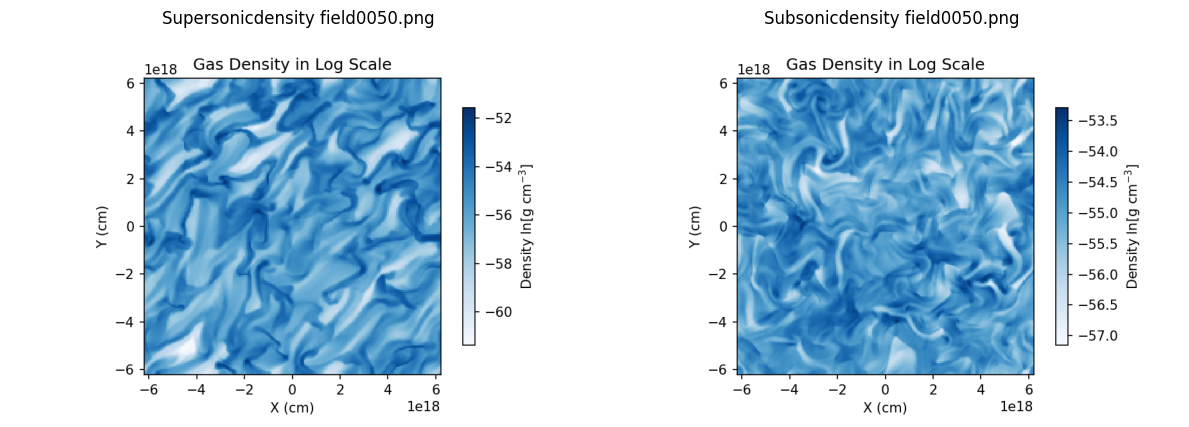

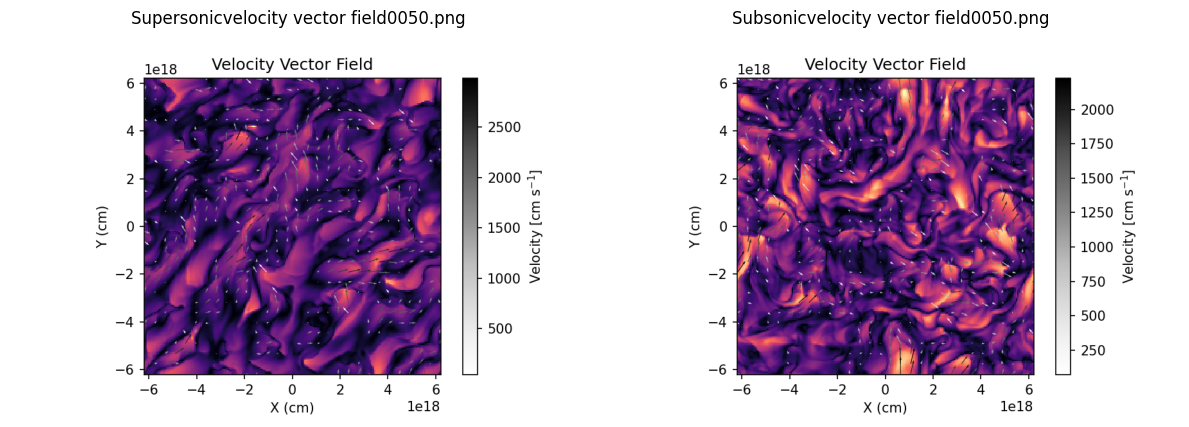

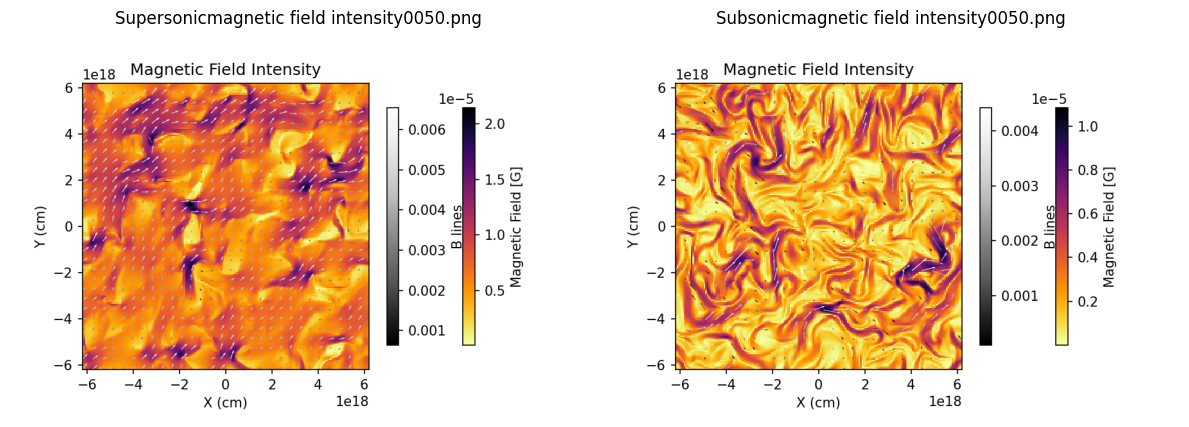

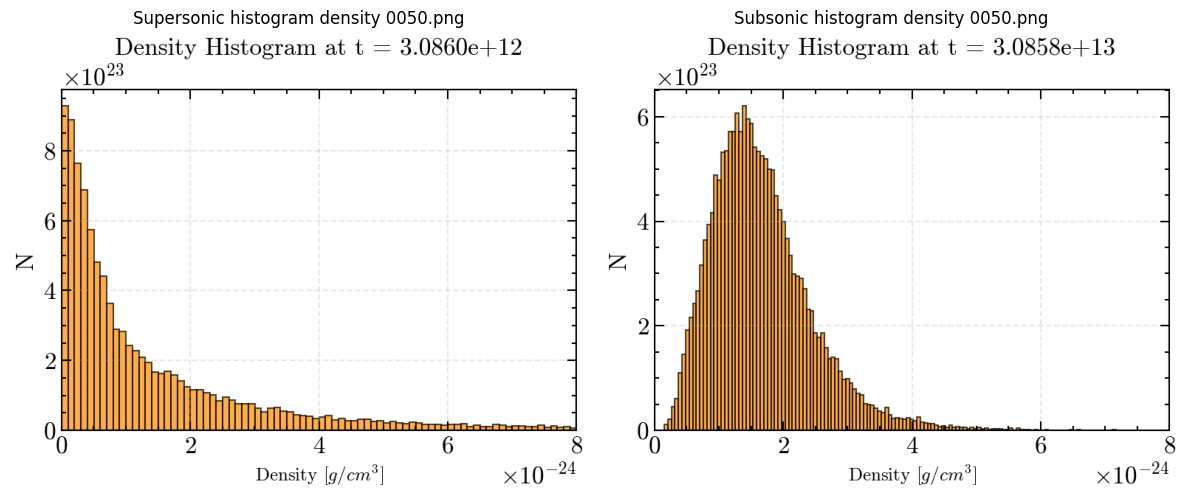

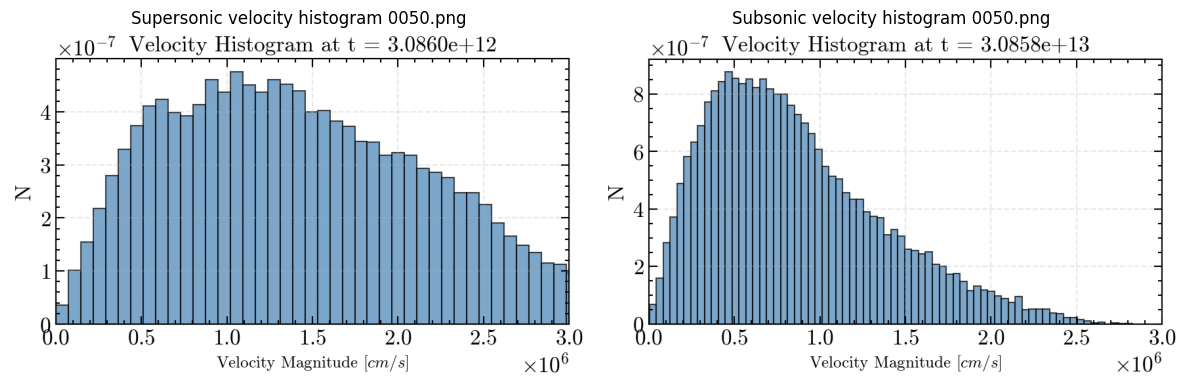

In [14]:
#Use the names of the files to plot this in a two panel plot:
# supersonic_file=["Supersonic_density_field_0050.png","Supersonic_velocity_vector_field_0050.png", "Supersonic_magnetic_field_0050.png"]
# subsonic_file=["Subsonic_density_field_0050.png","Subsonic_velocity_vector_field_0050.png","Subsonic_magnetic_field_0050.png"]

##Make the variables that are necessary for the plots 
supersonic_file=supersonic_1+supersonic_hist
subsonic_file= subsonic_1+subsonic_hist

save_name=[f"Composed_Density_field{num:04d}",f"Composed_Velocity_vector_field{num:04d}",f"Composed_Magnetic_field{num:04d}",\
           f"Composed_Histogram_density{num:04d}", f"Composed_Histogram_velocity{num:04d}"]
title_left = generate_titles(supersonic_file)

title_right = generate_titles(subsonic_file)

#Combined Plot:
iterat=0
for iterat in range(len(supersonic_file)):
    create_2_panel_figure(directory_name, supersonic_file[iterat], subsonic_file[iterat], save_name[iterat], title_left[iterat], title_right[iterat], True)

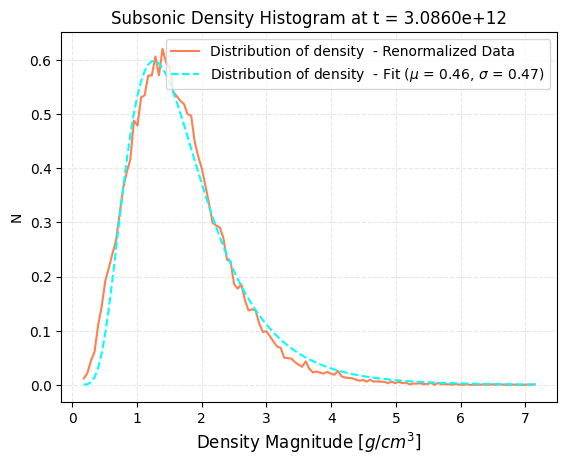

In [15]:
#Check distribution of the density histogram 
title_sub= f"Subsonic Density Histogram at t = {t_cgs[num]:.4e}"
xlabel=r"Density Magnitude [$g/cm^3$]"
ylabel=r"N"
fit_and_plot_log_normal(rho_cgs_sub,title_sub, "Distribution of density ",xlabel,ylabel, "coral","aqua", 1.e-24, 1.e24)


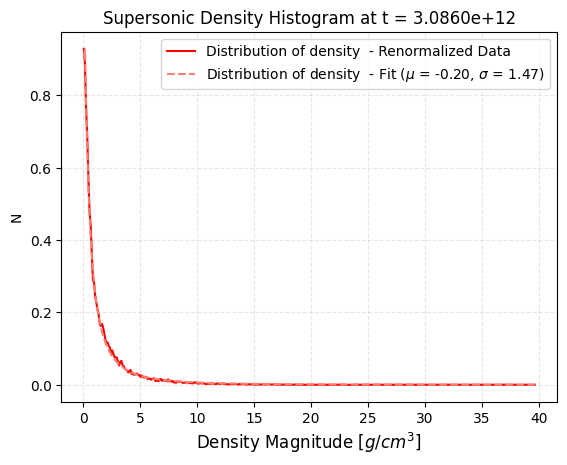

In [16]:
#Check distribution of the density histogram 
title_sup= f"Supersonic Density Histogram at t = {t_cgs[num]:.4e}"
xlabel=r"Density Magnitude [$g/cm^3$]"
ylabel=r"N"
fit_and_plot_log_normal(rho_cgs_sup,title_sup, "Distribution of density ",xlabel,ylabel, "red","salmon", 1.e-24, 1.e24)


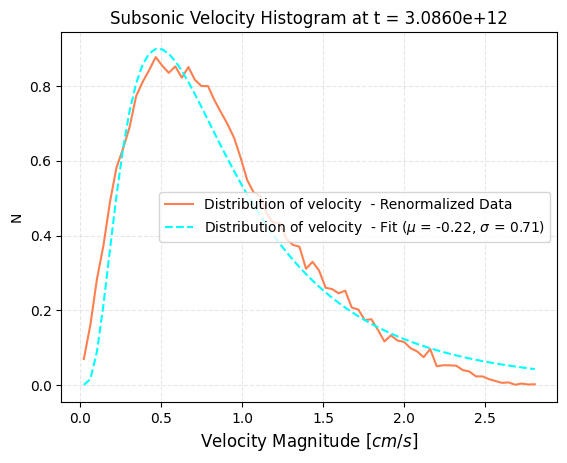

In [17]:
#check distribution of velocity histogram
title_sub= f"Subsonic Velocity Histogram at t = {t_cgs[num]:.4e}"
xlabel=r"Velocity Magnitude [$cm/s$]"
ylabel=r"N"
fit_and_plot_log_normal(vel_mag_1d_sub,title_sub, "Distribution of velocity ",xlabel,ylabel, "coral","aqua", 1.e6, 1.e-6)

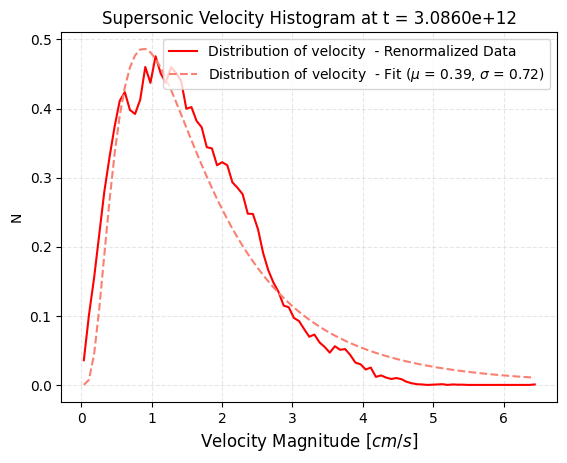

In [18]:
#check distribution of velocity histogram
title_sup= f"Supersonic Velocity Histogram at t = {t_cgs[num]:.4e}"
xlabel=r"Velocity Magnitude [$cm/s$]"
ylabel=r"N"
fit_and_plot_log_normal(vel_mag_1d_sup,title_sup, "Distribution of velocity ",xlabel,ylabel, "red","salmon", 1.e6, 1.e-6)

With this, we can observe that the density and velocity fields follow a log-normal distribution. In the supersonic velocity distribution, we observe more abrupt changes, whereas in the subsonic distribution, the changes are smoother. For the density distribution, the supersonic flow exhibits notable variations, while in the subsonic flow, the changes appear more gradual.



## 3. (6 points) Numerical differentiation and shock candidates:

Create a set of Python functions that:

(g) Isolate candidate shocked cells in binary fields, based on the following methods:

- **Method 1:** Read a 2D velocity vector field. Compute the divergence of the velocity field and isolate the cells where there are convergent flows (i.e. where $\vec\nabla\cdot \vec v <\alpha$, where $\alpha=0$). Cells with convergent flows are candidate shocked cells. Try with $\alpha$ values slightly lower than $0$ for better results.

- **Method 2:** Calculate the 2D pressure field using the equation of state of isothermal gas, i.e. $p=\rho\,c_{\rm iso}^2$. Compute the gradient of the pressure and isolate the cells with large pressure gradients (i.e. where $\frac{|\vec\nabla P|}{P}>0.01\max{\left(\frac{|\vec\nabla P|}{P}\right)}$). Such cells are candidate shocked cells.

(h) Call your shock-finding function/s from (g) for VTK file # 50 of each simulation, and make binary maps of the resulting candidate shock cells from both methods and for both models. Show the results as follows:

- A 2-panel figure showing the supersonic (left) and subsonic (right) shocked cell candidates, computed from method 1.

- A 2-panel figure showing the supersonic (left) and subsonic (right) shocked cell candidates, computed from method 2.

(i) Compute 1D histograms of the shock cell candidates from both methods and for both models, and make the following figures:

- A 2-panel figure showing the supersonic (left) and subsonic (right) shocked cell candidates, computed from method 1.

- A 2-panel figure showing the supersonic (left) and subsonic (right) shocked cell candidates, computed from method 2.

(j) Analyse your results, in particular:

- Do the shock candidate results of methods 1 and 2 agree? Why?

- Do you find similar distributions of shock candidates in both turbulence models? Which model has more shocks? Why?



In [19]:
def method1_divergence(vx1_cgs2D, vx2_cgs2D, coord_vect, threshold):
    """
    Identify shock candidate cells based on velocity divergence.

    Parameters:
        vx1_cgs2D (2D array): Velocity in the x-direction (cgs units).
        vx2_cgs2D (2D array): Velocity in the y-direction (cgs units).
        coord_vect (tuple): A tuple containing 1D arrays for grid coordinates (x, y).
        threshold (float): Convergence threshold.

    Returns:
        shocked_cells (2D array): Cells where divergence is below threshold.
        binary_map (2D array): Binary map of convergence cells (True if divergence below threshold).
    """
    x, y = coord_vect
    dx = float(x[1] - x[0])  # Grid spacing in the x-direction
    dy = float(y[1] - y[0])  # Grid spacing in the y-direction
    
    # Compute the velocity gradients
    dvx = np.gradient(vx1_cgs2D, dx, axis=1)  # Gradient of vx1 in x-direction
    dvy = np.gradient(vx2_cgs2D, dy, axis=0)  # Gradient of vx2 in y-direction
    
    # Compute the velocity divergence (sum of gradients)
    div = dvx + dvy

    # Identify shock candidate cells based on the divergence being below the threshold
    shocked_cells = np.where(div < threshold, div, 0)  # Only keep the values below threshold
    binary_map = div < threshold  # Binary map of shocked cells (True if div < threshold)

    return shocked_cells, binary_map


def method2_pressure_gradient(rho_cgs2D, cs, coord_vect, threshold):
    """
    Identify shock candidate cells based on the pressure gradient magnitude.

    Parameters:
        rho_cgs2D (2D array): Density field (cgs units).
        cs (float): Sound speed (assumed constant here).
        coord_vect (tuple): A tuple containing 1D arrays for grid coordinates (x, y).
        threshold (float): Pressure gradient magnitude threshold.

    Returns:
        shocked_cells (2D array): Cells where pressure gradient exceeds the threshold.
        binary_map (2D array): Binary map of shocked cells (True if gradient exceeds threshold).
    """
    # Compute the pressure field: P = rho * cs^2
    pressure = rho_cgs2D * cs**2

    x, y = coord_vect
    dx = float(x[1] - x[0])  # Grid spacing in the x-direction
    dy = float(y[1] - y[0])  # Grid spacing in the y-direction
    
    # Compute the pressure gradient components
    dp_dx = np.gradient(pressure, dx, axis=1)  # Pressure gradient in x-direction
    dp_dy = np.gradient(pressure, dy, axis=0)  # Pressure gradient in y-direction
    
    # Compute the magnitude of the gradient
    gradient_magnitude = np.sqrt(dp_dx**2 + dp_dy**2)

    # Identify shocked cells based on the gradient magnitude exceeding the threshold
    shocked_cells = np.where((gradient_magnitude / pressure) > (threshold * np.max(gradient_magnitude / pressure)),
                             gradient_magnitude, 0)  # Keep values above threshold
    binary_map = (gradient_magnitude / pressure) > (threshold * np.max(gradient_magnitude / pressure))  # Binary map

    return shocked_cells, binary_map



In [20]:
def shocked_plots(binary_map_method_1, binary_map_method_2, shocked_1, shocked_2, grid, identifier, num, directory_name, hist):
    """
    Plot binary shock candidate maps and histograms for two methods, and save the figures.

    Parameters:
        binary_map_method_1 (2D array): Binary shock candidates for Method 1.
        binary_map_method_2 (2D array): Binary shock candidates for Method 2.
        shocked_1 (1D array or flattened): Shock values from Method 1.
        shocked_2 (1D array or flattened): Shock values from Method 2.
        grid (tuple): Tuple of (x, y) arrays for the spatial grid.
        identifier (str): Identifier string for the title.
        num (int): Sequential number for saving the plots with unique filenames.
        directory_name (str): Directory path where figures will be saved.

    Returns:
        file_list_bin (list): List of paths to saved binary map plots.
        file_list_hist (list): List of paths to saved histogram plots.
    """
    # Ensure the directory exists
    try:
        os.mkdir(directory_name)
        print(f"Directory '{directory_name}' created successfully.")
    except FileExistsError:
        print(f"Directory '{directory_name}' already exists.")
    except PermissionError:
        print(f"Permission denied: Unable to create '{directory_name}'.")
    except Exception as e:
        print(f"An error occurred: {e}")
    file_list_bin = []  # For binary maps
    file_list_hist = []  # For histograms
    file_list_bin_m1 = []
    file_list_bin_m2 = []
    # Filter out the zero values for histograms
    data_shocked1 = np.abs(shocked_1.flatten())
    data_filtered_shocked1 = data_shocked1[data_shocked1 != 0]
    data_shocked2 = np.abs(shocked_2.flatten())
    data_filtered_shocked2 = data_shocked2[data_shocked2 != 0]

    # Method 1: Plot Binary Map
    #Add exceptions:
    file_dir_map_bin_m1 = f"{identifier}_method_1_map_{num:04d}.png"
    # if not os.path.exists(file_dir_map_bin_m1):
    with plt.style.context(['science', 'notebook', 'no-latex']):
        plt.figure(figsize=(6, 4))
        plt.title(f"{identifier} - Method 1 - {num}")
        plt.xlabel('X (cm)')
        plt.ylabel('Y (cm)')
        z1 = plt.pcolormesh(grid[0], grid[1], binary_map_method_1, cmap="binary", shading="auto")
        cb1 = plt.colorbar(z1, shrink=0.8)
        cb1.set_label(r"Shock Candidates [Binary]")
        plt.gca().set_aspect('auto')
        file_path = f"{directory_name}/{identifier}_method_1_map_{num:04d}.png"
        plt.savefig(file_path, dpi=150)
        file_list_bin.append(f"{identifier}_method_1_map_{num:04d}.png")
        file_list_bin_m1.append(f"{identifier}_method_1_map_{num:04d}.png")
        plt.close()
    # else:
    #     print("The file already exist.")
    if hist==1:
    # Method 1: Plot Histogram
        file_dir_hist_m1 = f"{directory_name}/{identifier}_method_1_histogram_{num:04d}.png"
        # if not os.path.exists(file_dir_hist_m1):
          
        with plt.style.context(['science', 'notebook', 'no-latex']):
            plt.figure(figsize=(6, 4))
            plt.title(f"Histogram {identifier} - Method 1 - {num}")
            plt.xlabel('Shock Values')
            plt.ylabel('Frequency')
            
            plt.hist(data_filtered_shocked1, edgecolor='black', bins=50, color="steelblue", density=True)
            file_path = f"{directory_name}/{identifier}_method_1_histogram_{num:04d}.png"
            plt.savefig(file_path, dpi=150)
            file_list_hist.append(f"{identifier}_method_1_histogram_{num:04d}.png")
            plt.close()
    # else:
    #     print("The file already exist.")
        
    # Method 2: Plot Binary Map
    file_dir_map_bin_m2 = f"{identifier}_method_2_map_{num:04d}.png"
    # if not os.path.exists(file_dir_map_bin_m2):
    with plt.style.context(['science', 'notebook', 'no-latex']):
        plt.figure(figsize=(6, 4))
        plt.title(f"{identifier} - Method 2 - {num}")
        plt.xlabel('X (cm)')
        plt.ylabel('Y (cm)')
        z2 = plt.pcolormesh(grid[0], grid[1], binary_map_method_2, cmap="binary", shading="auto")
        cb2 = plt.colorbar(z2, shrink=0.8)
        cb2.set_label(r"Shock Candidates [Binary]")
        plt.gca().set_aspect('auto')
        file_path = f"{directory_name}/{identifier}_method_2_map_{num:04d}.png"
        plt.savefig(file_path, dpi=150)
        file_list_bin.append(f"{identifier}_method_2_map_{num:04d}.png")
        file_list_bin_m2.append(f"{identifier}_method_2_map_{num:04d}.png")
        plt.close()
    # else:
    #       print("The file already exist.")
        
    # Method 2: Plot Histogram
    if hist==1:
        file_dir_hist_m2 = f"{directory_name}/{identifier}_method_2_histogram_{num:04d}.png"
        # if not os.path.exists(file_dir_hist_m2):
          
        with plt.style.context(['science', 'notebook', 'no-latex']):
            plt.figure(figsize=(6, 4))
            plt.title(f"Histogram {identifier} - Method 2 - {num}")
            plt.xlabel('Shock Values')
            plt.ylabel('Frequency')
            plt.hist(data_filtered_shocked2, edgecolor='black', bins=50, color="steelblue", density=True)
            file_path = f"{directory_name}/{identifier}_method_2_histogram_{num:04d}.png"
            plt.savefig(file_path, dpi=150)
            file_list_hist.append(f"{identifier}_method_2_histogram_{num:04d}.png")
            plt.close()
    # else:
    #     print("The file already exist.")
        

    return file_list_bin, file_list_hist, file_dir_map_bin_m1, file_dir_map_bin_m2


In [21]:
##Plot the Subsonic system:
#Here change the path for Supersonic folder
fname_sup="/home/klaus/CP1/Homeworks/HW2/TURB_DRIVE_SUB_hr/"
#Identify the type of file: 
identifier="Subsonic"

# define the folder that we will use:
directory_name = "output_data"
#Get the normalized constants 
constants_normalized=IO_units_out(fname_sup) #nrho_0, nl_0, nv_0, c_iso_0, nB_0, nt_0
#Get the t_cgs for name the histograms
t_cgs = IO_vtk_out(fname_sup,constants_normalized[5])

#Define the number of the file that are going to use:
num = 50
#Define the resize to get a visualization of the magnetic field:
B_shape_2D_resize=20
V_shape_2D_resize=20
path = f"{fname_sup}data.{num:04d}.vtk"

#Get the data of the VTK file
mesh_from_vtk, cgs_values, cgs_values_2D = read_VTK(path, constants_normalized)


#Third question- constants required:
cs = constants_normalized[3]
vx1_cgs2D = cgs_values_2D[1]
vx2_cgs2D = cgs_values_2D[2]
rho_cgs2D = cgs_values_2D[0]
#Get the coord vector:
interpolated_data = generate_and_interpolate(mesh_from_vtk, cgs_values_2D, nl_0, B_shape_2D_resize,V_shape_2D_resize)
coord_vect= interpolated_data[2]
grid = interpolated_data[3]
# print(coord_vect)
# Method 1:
threshold = -1e-12
shockedm1, binary_map_method_1 = method1_divergence(vx1_cgs2D, vx2_cgs2D, coord_vect, threshold)

# Method 2:
threshold = 0.11
shockedm2, binary_map_method_2 = method2_pressure_gradient(rho_cgs2D, cs, coord_vect, threshold)
#Apply this for the 
file_list_bin_sub, file_list_hist_sub, file_list_bin_m1, file_dir_map_bin_m2=shocked_plots(binary_map_method_1,binary_map_method_2, shockedm1, shockedm2, grid, identifier, num, directory_name, 1)


Directory 'output_data' already exists.


In [22]:
##Plot the Supersonic system:
#Here change the path for Supersonic folder
identifier = "Supersonic"
fname_sup="/home/klaus/CP1/Homeworks/HW2/TURB_DRIVE_SUP_hr/"

# define the folder that we will use:
directory_name = "output_data"
#Get the normalized constants 
constants_normalized=IO_units_out(fname_sup) #nrho_0, nl_0, nv_0, c_iso_0, nB_0, nt_0
#Get the t_cgs for name the histograms
t_cgs = IO_vtk_out(fname_sup,constants_normalized[5])

#Define the number of the file that are going to use:
num = 50
#Define the resize to get a visualization of the magnetic field:
B_shape_2D_resize=20
path = f"{fname_sup}data.{num:04d}.vtk"

#Get the data of the VTK file
mesh_from_vtk, cgs_values, cgs_values_2D = read_VTK(path, constants_normalized)


#Third question- constants required:
cs = constants_normalized[3]
vx1_cgs2D = cgs_values_2D[1]
vx2_cgs2D = cgs_values_2D[2]
rho_cgs2D = cgs_values_2D[0]


#Get the coord vector:
interpolated_data = generate_and_interpolate(mesh_from_vtk, cgs_values_2D, nl_0, B_shape_2D_resize,V_shape_2D_resize)
coord_vect= interpolated_data[2]
grid = interpolated_data[3]

# Method 1:
threshold = -1e-12
shockedm1, binary_map_method_1 = method1_divergence(vx1_cgs2D, vx2_cgs2D, coord_vect, threshold)

# Method 2:
threshold = 0.025
shockedm2, binary_map_method_2 = method2_pressure_gradient(rho_cgs2D, cs, coord_vect, threshold)
#Apply this for the 
file_list_bin_sup, file_list_hist_sup, file_list_bin_m1, file_dir_map_bin_m2 = shocked_plots(binary_map_method_1,binary_map_method_2, shockedm1, shockedm2, grid, identifier, num, directory_name, 1)


Directory 'output_data' already exists.


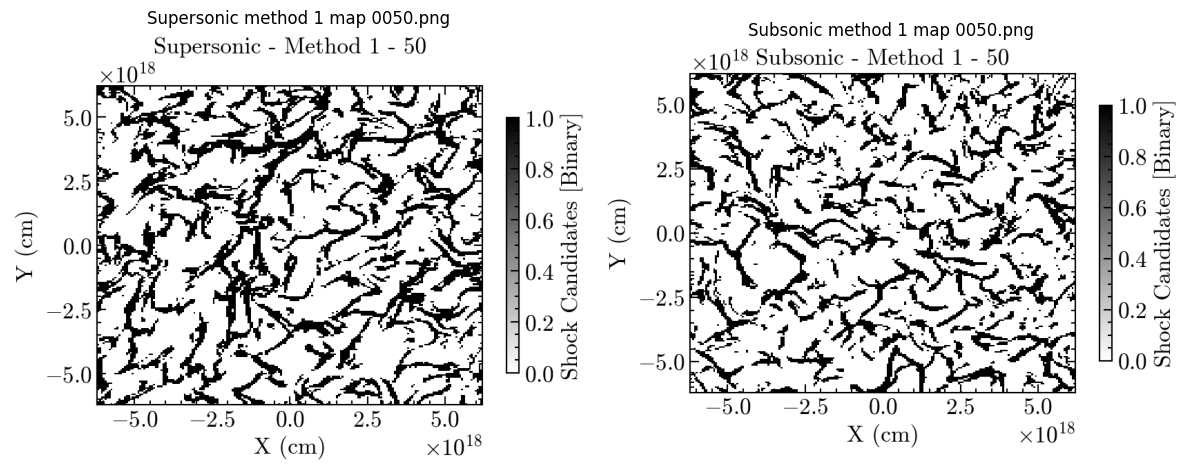

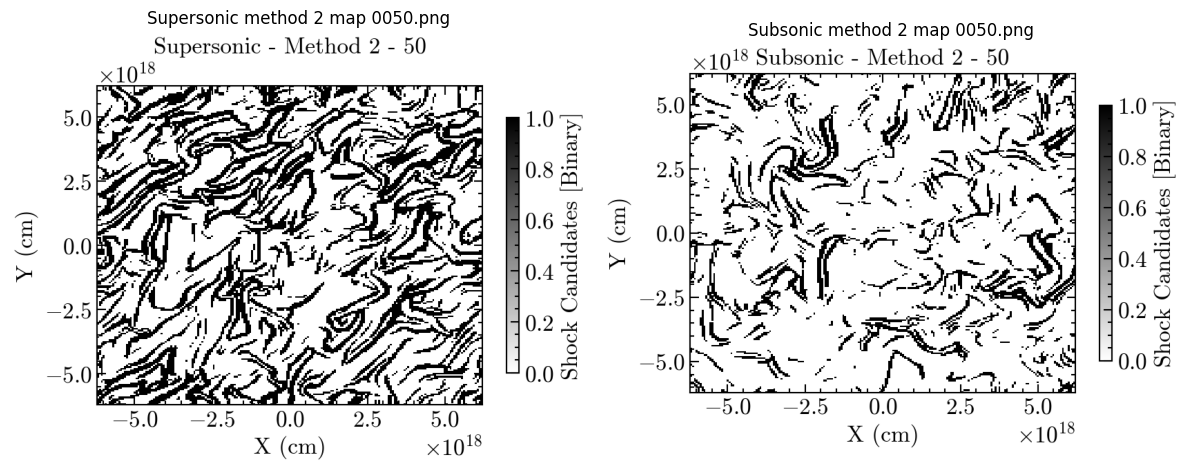

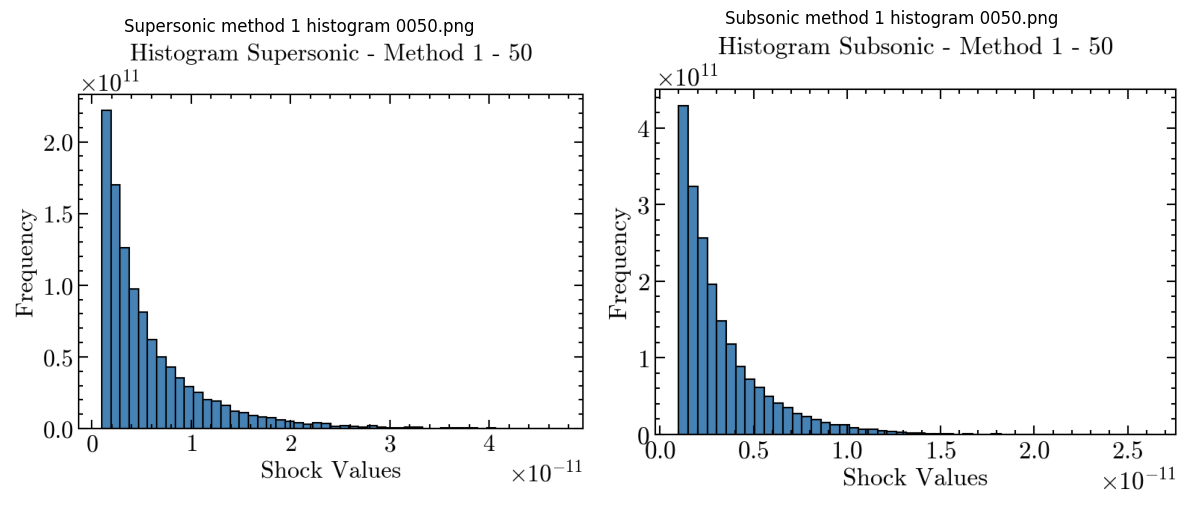

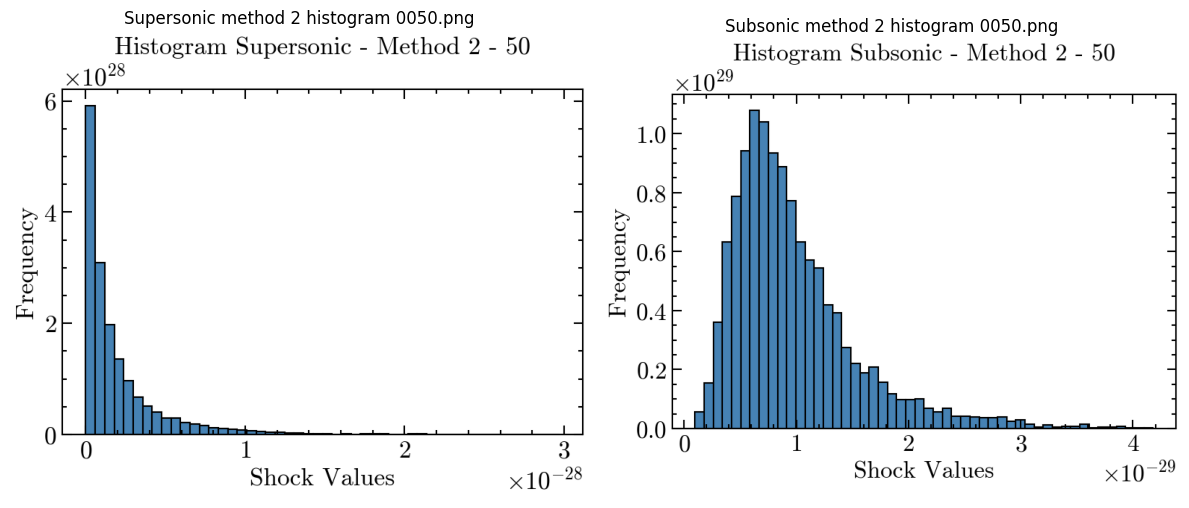

In [23]:
supersonic_file=file_list_bin_sup+file_list_hist_sup
subsonic_file= file_list_bin_sub+file_list_hist_sub

save_name=[f"Composed_bin_map_meth_1_{num:04d}",f"Composed_hist_meth_1_{num:04d}", f"Composed_bin_map_meth_2_{num:04d}", f"Composed_hist_meth_2_{num:04d}"]
title_left = generate_titles(supersonic_file)

title_right = generate_titles(subsonic_file)

#Combined Plot:
iterat=0
for iterat in range(len(supersonic_file)):
    create_2_panel_figure(directory_name, supersonic_file[iterat], subsonic_file[iterat], save_name[iterat], title_left[iterat], title_right[iterat],True)

In comparison figures 1 and 50 with the values as free parameter of 0, -1e-12, -1e-11, -1e-13, 1e-11, and 1e-12 for Method 1, it is evident that the results for -1e-12 and -1e-11 are significantly different. This is especially noticeable in the case of the first plot.

For Method 2, values close to 0 lead to the detection of more shock cells.

Both methods reveal some similar patterns, but not all, due to the different focus of each. Method 1 (velocity divergence) identifies regions where flows are converging, which often coincide with shock formation. On the other hand, Method 2 (pressure gradient) detects variations in pressure across space, which does not necessarily depend on abrupt changes in velocity divergence. Therefore, Method 2 can detect shocks or pressure jumps even if there aren't significant changes in the velocity field


## 4. (6 points) Numerical integration and custom outputs:

(k) Create a python function that loops over all VTK files in a simulation, and saves maps (in both PNG and VTK-like format) of the shock cell candidates for all times. Add time stamps in physical units to the maps. Please don't attach any output files to your emails. Your codes should produce them when I run them locally.

(l) Create a python function that loops over all VTK files, and computes the following integrated quantities for each time:

- the total number of shock candidates, $N_{\rm shocks}$ computed from each method 1 and 2,

- the (volume-weighted) average velocity dispersion, $\sigma_v = \sqrt{[ v^2 ] - [v ]^2}$,

- the rms Mach number, ${\cal M}_{\rm rms}$, for which you need $c_{\rm iso}$ given in **units.out**,

and returns:

- a CSV file with 5 columns, time on the first column, and the above quantities in the next ones. There is no need to attach the CSV file to your emails, your code should produce the file locally when I run it.

(m) Call your function from (l) for each simulation set (supersonic and subsonic) and use the CSV files to make the following plots:

- A 2-panel figure showing the supersonic (left) and subsonic (right) $N_{\rm shocks}$ time.

- A 2-panel figure showing the supersonic (left) and subsonic (right) ${\cal M}_{\rm rms}$ versus time.

(n) Analyse your results, in particular:

- Does the flow reach steady state in both models? At what times?
  
- Is there a relation between $N_{\rm shocks}$ and ${\cal M}_{\rm rms}$?


In [24]:
x_vtk = np.linspace(mesh_from_vtk.bounds[0], mesh_from_vtk.bounds[1], mesh_from_vtk.dimensions[1]) 
y_vtk = np.linspace(mesh_from_vtk.bounds[2], mesh_from_vtk.bounds[3], mesh_from_vtk.dimensions[0]) 
binary_map_method_1_flat = binary_map_method_1.astype(int).flatten()
# shockedm1 = shockedm1.flatten()
name_test="vtk_50"
gridToVTK(path=f'{directory_name}/{name_test}', x = x_vtk, y= y_vtk, z= np.zeros(1) ,cellData={'shocked_cells_m1':binary_map_method_1_flat} )
    

'/home/klaus/CP1/Homeworks/HW2/output_data/vtk_50.vtr'

In [26]:
###Please check units and save correctly
def save_maps_and_vtk(directory_name, num_files, fname, identifier, mesh_from_vtk, hist):
    """
    Processes VTK data files, generates shock maps, saves binary shock maps as VTK files, and creates histograms for shocked regions.

    This function performs the following tasks:
    1. Creates a specified directory if it doesn't already exist.
    2. Iterates over a given number of VTK files (`num_files`), and for each file:
        - Reads the VTK data and the associated constants.
        - Interpolates physical quantities from the VTK data to a 2D grid.
        - Applies two methods (method 1: divergence-based, method 2: pressure gradient-based) to detect shocked regions.
        - Generates binary maps based on the shock detection methods.
        - Saves the binary shock maps and the corresponding histograms.
        - Saves the shock maps as VTK files for further analysis.
    
    The function supports both **Supersonic** and **Subsonic** shock identification and uses different thresholds for these two cases.

    Parameters:
    - directory_name: str
        The directory where the generated VTK files and histograms will be saved.
    - num_files: int
        The number of VTK files to process. Each file represents a timestep or iteration in the simulation.
    - fname: str
        The file name prefix used to access the VTK data and constants.
    - identifier: str
        A string that identifies the type of shock ('Supersonic' or 'Subsonic') for different thresholding.
    - mesh_from_vtk: vtk object
        The VTK mesh object containing the spatial information of the simulation grid.
    - hist: bool
        A flag to determine if histograms of shocked regions should be generated and saved.

    Returns:
    - all_file_dir_map_bin_m1: list
        A list of file paths for binary maps generated by method 1 (divergence-based shock detection).
    - all_file_dir_map_bin_m2: list
        A list of file paths for binary maps generated by method 2 (pressure gradient-based shock detection).
    
    Notes:
    - The function saves the generated shock maps as VTK files for both shock detection methods.
    - For each VTK file processed, the corresponding shock map files are saved with filenames containing the index `num`.
    - Histograms of the shocked regions (density, velocity) are saved as PNG images, with appropriate labeling based on the simulation timestep.
    """
    x_vtk = np.linspace(mesh_from_vtk.bounds[0], mesh_from_vtk.bounds[1], mesh_from_vtk.dimensions[1]) 
    y_vtk = np.linspace(mesh_from_vtk.bounds[2], mesh_from_vtk.bounds[3], mesh_from_vtk.dimensions[0]) 
    
    # Create the directory
    try:
        os.mkdir(directory_name)
        # print(f"Directory '{directory_name}' created successfully.")
    except FileExistsError:
        print(f"Directory '{directory_name}' already exists.")
    except PermissionError:
        print(f"Permission denied: Unable to create '{directory_name}'.")
    except Exception as e:
        print(f"An error occurred: {e}")
    name_bin_files= []
    all_file_dir_map_bin_m1 = []
    all_file_dir_map_bin_m2 = []
    for num in range(num_files):
        #Get the normalized constants 
        constants_normalized=IO_units_out(fname) #nrho_0, nl_0, nv_0, c_iso_0, nB_0, nt_0
        #Get the t_cgs for name the histograms
        t_cgs = IO_vtk_out(fname,constants_normalized[5])
        B_shape_2D_resize=20
        V_shape_2D_resize=30
        path = f"{fname}data.{num:04d}.vtk"
        
        #Get the data of the VTK file
        mesh_from_vtk, cgs_values, cgs_values_2D = read_VTK(path, constants_normalized)

        nl_0= constants_normalized[1]# this could be putted directly...
        #Generate the coord vectors, and interpolates to physical quantities:
        interpolated_data = generate_and_interpolate(mesh_from_vtk, cgs_values_2D, nl_0, B_shape_2D_resize,V_shape_2D_resize)

        coord_vect = interpolated_data[2]
        grid = interpolated_data[3]
        #Third question- constants required:
        cs = constants_normalized[3]
        vx1_cgs2D = cgs_values_2D[1]
        vx2_cgs2D = cgs_values_2D[2]
        rho_cgs2D = cgs_values_2D[0]

        if identifier=="Supersonic":
            
            threshold_div = -1e-12
            threshold_grad = 0.025
        else:
            threshold_div = -1e-12
            threshold_grad = 0.11
            
        # Method 1:
        shockedm1, binary_map_method_1 = method1_divergence(vx1_cgs2D, vx2_cgs2D, coord_vect, threshold_div)
        
        # Method 2:
        
        shockedm2, binary_map_method_2 = method2_pressure_gradient(rho_cgs2D, cs, coord_vect, threshold_grad)
        #Apply this for the 
        file_list_bin, file_list_hist, file_dir_map_bin_m1, file_dir_map_bin_m2 = shocked_plots(binary_map_method_1, binary_map_method_2, shockedm1, shockedm2, grid, identifier, num, directory_name, hist)
        all_file_dir_map_bin_m1.append(file_dir_map_bin_m1)
        all_file_dir_map_bin_m2.append(file_dir_map_bin_m2)
        binary_map_method_1_flat = binary_map_method_1.astype(int).flatten()
        binary_map_method_2_flat = binary_map_method_2.astype(int).flatten()
        gridToVTK(path=f'{directory_name}/vtk_met_1_{num}', x = x_vtk, y= y_vtk, z= np.zeros(1) ,cellData={'shocked_cells_m1':binary_map_method_1_flat} )
        gridToVTK(path=f'{directory_name}/vtk_met_2_{num}', x = x_vtk, y= y_vtk, z= np.zeros(1) ,cellData={'shocked_cells_m1':binary_map_method_2_flat} )
    
        # gridToVTK(path='', x = x_vtk, y= y_vtk, cellData={'shocked_cells_m1'} )
    return all_file_dir_map_bin_m1, all_file_dir_map_bin_m2
        
# #Here change the path for Supersonic folder
# identifier = "Supersonic"
# fname="/home/klaus/CP1/Homeworks/HW2/TURB_DRIVE_SUP_hr/"

# # define the folder that we will use:
# directory_name = "output_data"
# num_files = 101
# save_maps_and_vtk(directory_name, num_files, fname, identifier)

In [30]:
def total_shock(directory_name, num_files, name_new_file, fname, threshold_1, threshold_2):
    """
    Analyzes shock candidates in a series of VTK files and saves the results in a CSV file.

    This function processes multiple VTK files to detect shocks using two methods:
    1. **Method 1**: Divergence of velocity.
    2. **Method 2**: Pressure gradient.

    For each file, it computes:
    - Number of shocks from each method.
    - Velocity dispersion (\(\sigma_v\)) and Mach number.
    
    The results are saved in a CSV file with columns for time, shock counts, velocity dispersion, and Mach number.

    Parameters:
    - directory_name (str): Path to save the results CSV.
    - num_files (int): Number of VTK files to process.
    - name_new_file (str): Name of the output CSV file.
    - fname (str): Base name for reading the VTK files and other data.
    - threshold_1 (float): Threshold for shock detection in **Method 1**.
    - threshold_2 (float): Threshold for shock detection in **Method 2**.

    Returns:
    - name_file (str): Path to the generated CSV file containing the results.
    """
    #Create a file:
    file = open(f"{directory_name}/{name_new_file}.csv", "w")
    
    # Write a header
    file.write("time,N_shocks_Method1,N_shocks_Method2,Sigma_v,M_rms\n")
    file.close()
    num_shock_meth_1=[]
    num_shock_meth_2=[]
    for num in range(num_files):
        # print("entered ", num)
        # Get the normalized constants required for unit conversion
        # These include normalized density, length, velocity, speed of sound, magnetic field, and time.
        constants_normalized = IO_units_out(fname)
        
        # Compute the time in CGS units (used later for naming or labeling histograms)
        t_cgs = IO_vtk_out(fname, constants_normalized[5])
        
        # Construct the file path for the current VTK file
        path = f"{fname}/data.{num:04d}.vtk"

        #Define the resize to get a visualization of the magnetic field:
        B_shape_2D_resize=30
        V_shape_2D_resize=30
        
        nl_0= constants_normalized[1]
        # Read data from the VTK file
        # Returns: mesh information, CGS-scaled 3D field values, and CGS-scaled 2D field values
        mesh_from_vtk, cgs_values, cgs_values_2D = read_VTK(path, constants_normalized)
        
        interpolated_data = generate_and_interpolate(mesh_from_vtk, cgs_values_2D, nl_0, B_shape_2D_resize,V_shape_2D_resize)
        coord_vect= interpolated_data[2]
        grid = interpolated_data[3]
        # Extract relevant physical quantities from the normalized constants
        cs = constants_normalized[3]  # Speed of sound isothermal
        cs= cs[0]
        # print(cs)
        vx1_cgs2D = cgs_values_2D[1]  # Velocity component in the x1 direction (2D slice)
        vx2_cgs2D = cgs_values_2D[2]  # Velocity component in the x2 direction (2D slice)
        rho_cgs2D = cgs_values_2D[0]  # Density field (2D slice)
        vel_magnitude2D = np.sqrt(vx1_cgs2D**2 + vx2_cgs2D**2)
        # Method 1: Detect shocks using divergence of velocity
        # threshold_1 = 0  # Threshold for identifying shocks in method 1
        shocked_m1, binary_map_method_1 = method1_divergence(vx1_cgs2D, vx2_cgs2D, coord_vect, threshold_1)
        
        # Method 2: Detect shocks using pressure gradient
        # threshold_2 = 0.3  # Threshold for identifying shocks in method 2
        shocked_m2, binary_map_method_2 = method2_pressure_gradient(rho_cgs2D, cs, coord_vect, threshold_2)
        
        # Compute the total number of shock candidates detected in each method
        num_shock_1 = np.sum(binary_map_method_1.flatten().astype(int))  # Method 1 shock count
        num_shock_2 = np.sum(binary_map_method_2.flatten().astype(int))  # Method 2 shock count
        
        num_shock_meth_1.append(num_shock_1)
        num_shock_meth_2.append(num_shock_2)


        ## average velocity dispersion 
        #$\sigma_v = \sqrt{[ v^2 ] - [v ]^2}$
        # Constants required:
        # cs = constants_normalized[3]
        # # cs= cs[0]
        vx1_cgs = cgs_values[1]
        # print("vx_cgs",vx1_cgs.shape)
        vx2_cgs = cgs_values[2]
        # rho_cgs2D = cgs_values_2D[0]

        ##Continue here putting this avg velocity  dispersion
        vel_magnitude = np.sqrt(vx1_cgs**2 + vx2_cgs**2)
        
        # print(f"Type of vel_magnitude: {type(vel_magnitude)}")

        # vel_magnitude_sqr = vel_magnitude**2

        # avg_mag_vel_sqr = np.nanmean(vel_magnitude)
        
        # sqr_avg_vel_mag = np.nanmean(vel_magnitude)**2

        # sigma_v = np.sqrt(avg_mag_vel_sqr - sqr_avg_vel_mag)
        sigma_v = np.std(vel_magnitude2D)
        avg_mag_vel_sqr = np.sqrt(np.mean(vel_magnitude2D))
        mach_number = avg_mag_vel_sqr/cs
        # print(f"Type of t_cgs[num]: {type(t_cgs[num])}")
        
        # print(f"Type of num_shock_1: {type(num_shock_1)}")
        
        # print(f"Type of num_shock_2: {type(num_shock_2)}")
        
        # print(f"Type of sigma_v: {type(sigma_v)}")
        # print(f"Type of mach_number: {type(mach_number)}")

        #Write in the file
        try:
            with open(f"{directory_name}/{name_new_file}.csv", "a") as file:
                file.write(f"{t_cgs[num]:.4e}, {num_shock_1}, {num_shock_2}, {sigma_v:.4e}, {mach_number:.4e}\n")
        except Exception as e:
            print(f"Failed to write to file for index {num}: {e}")
        file.close()
        # print(i)
        if num==num_files-1:
            print("Saved")
        # Append results
        # results.append([t_cgs, num_shock_1, num_shock_2, sigma_v, mach_number])
        # Log the results for the current file
    num_shock_1_total = np.sum(num_shock_1.flatten().astype(int))  # Method 1 shock count
    num_shock_2_total = np.sum(num_shock_2.flatten().astype(int))  # Method 2 shock count
        
    print(f"File {num}: Shock Count Method 1 = {num_shock_1}, Method 2 = {num_shock_2}")
    name_file = f"{directory_name}/{name_new_file}.csv"
    return name_file

In [31]:
#Here change the path for Supersonic folder
identifier = "Supersonic"
fname="/home/klaus/CP1/Homeworks/HW2/TURB_DRIVE_SUP_hr/"

# define the folder that we will use:
directory_name = "output_data"
num_files = 101
file_dir_map_bin_m1_sup, file_dir_map_bin_m2_sup= save_maps_and_vtk(directory_name, num_files, fname, identifier, mesh_from_vtk, 0)
name_new_file_Sup = "stats"+"_sup"

csv_supersonic= total_shock(directory_name, num_files, name_new_file_Sup, fname, 0, 0.022)#Here change the path for Supersonic folder

##Here is the save for Subsonic folder
identifier = "Subsonic"
fname="/home/klaus/CP1/Homeworks/HW2/TURB_DRIVE_SUB_hr/"

# define the folder that we will use:
directory_name = "output_data"
num_files = 101
file_dir_map_bin_m1_sub, file_dir_map_bin_m2_sub = save_maps_and_vtk(directory_name, num_files, fname, identifier, mesh_from_vtk, 0)
name_new_file_Sub = "stats"+"_sub"

csv_subsonic = total_shock(directory_name, num_files, name_new_file_Sub, fname, 0, 0.08)

Directory 'output_data' already exists.
Directory 'output_data' already exists.
Directory 'output_data' already exists.
Directory 'output_data' already exists.
Directory 'output_data' already exists.
Directory 'output_data' already exists.
Directory 'output_data' already exists.
Directory 'output_data' already exists.
Directory 'output_data' already exists.
Directory 'output_data' already exists.
Directory 'output_data' already exists.
Directory 'output_data' already exists.
Directory 'output_data' already exists.
Directory 'output_data' already exists.
Directory 'output_data' already exists.
Directory 'output_data' already exists.
Directory 'output_data' already exists.
Directory 'output_data' already exists.
Directory 'output_data' already exists.
Directory 'output_data' already exists.
Directory 'output_data' already exists.
Directory 'output_data' already exists.
Directory 'output_data' already exists.
Directory 'output_data' already exists.
Directory 'output_data' already exists.


In [32]:
# print(file_dir_map_bin_m2_sub)

In [33]:
print(csv_subsonic)
print(csv_supersonic)

output_data/stats_sub.csv
output_data/stats_sup.csv


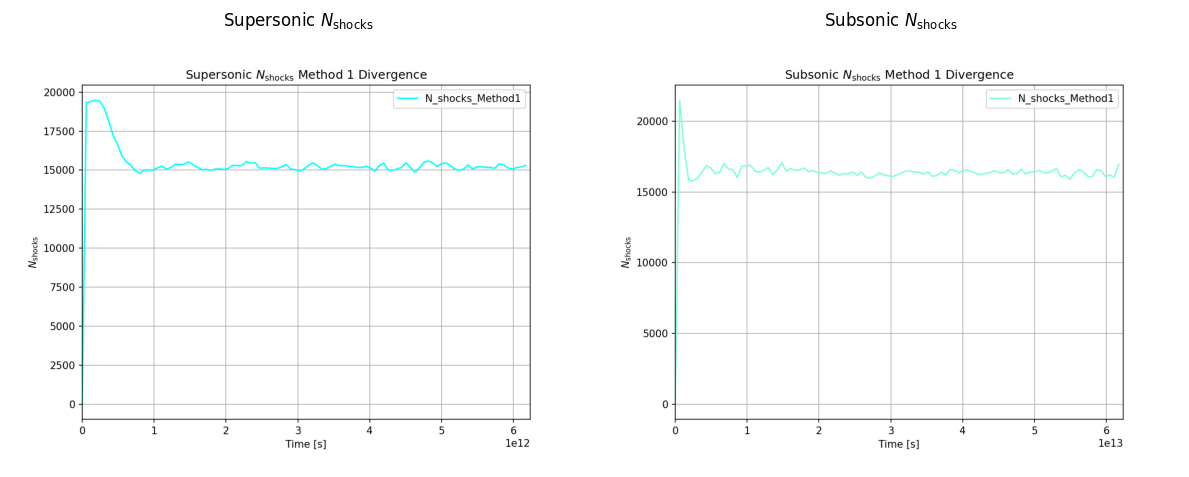

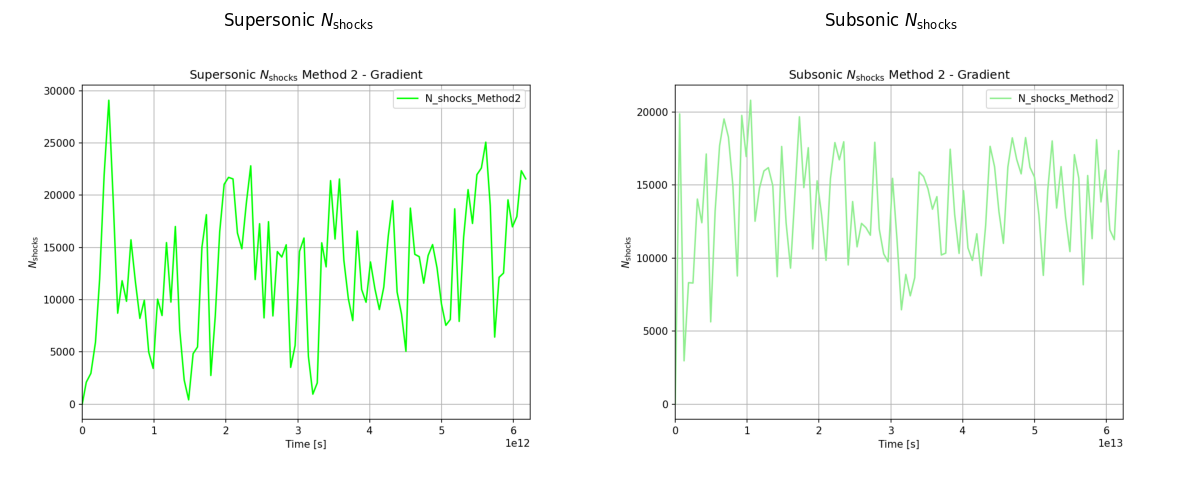

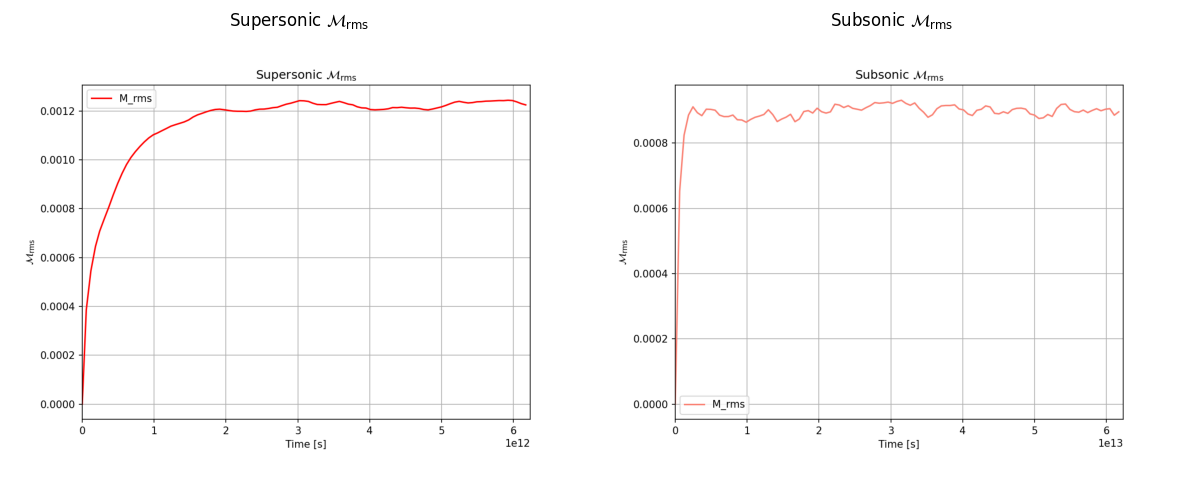

In [34]:

def generate_individual_plot(data, y_column, output_file, title, ylabel, color_var):
    """
    Generates and saves a plot for a specified column in the given data.

    Parameters:
    - data (pd.DataFrame): Data containing 'time' and the specified y_column.
    - y_column (str): Name of the column to plot on the y-axis.
    - output_file (str): Path to save the generated plot.
    - title (str): Title of the plot.
    - ylabel (str): Label for the y-axis.
    - color_var (str): Color for the plot line.

    Returns:
    - None
    """
    plt.figure(figsize=(8, 6))
    plt.plot(data['time'], data[y_column], label=y_column, color=f"{color_var}")
    plt.title(title)
    plt.xlabel('Time [s]')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    time_diff = data['time'].iloc[-1]-data['time'].iloc[-2]
    plt.xlim(0., data['time'].iloc[-1]+(time_diff))
    
    plt.savefig(output_file, dpi=150)
    plt.close()
supersonic_data = pd.read_csv(csv_supersonic)
subsonic_data = pd.read_csv(csv_subsonic)

# Generate individual plots for N_shocks Method 1:
##Supersonic
generate_individual_plot(
    supersonic_data,
    y_column='N_shocks_Method1',
    output_file=directory_name+'/supersonic_N_shocks_M1_div.png',
    title='Supersonic $N_{\\rm shocks}$ Method 1 Divergence',
    ylabel='$N_{\\rm shocks}$',
    color_var = "aqua"
)
##Subsonic
generate_individual_plot(
    subsonic_data,
    y_column='N_shocks_Method1',
    output_file=directory_name+'/subsonic_N_shocks_M1_div.png',
    title='Subsonic $N_{\\rm shocks}$ Method 1 Divergence',
    ylabel='$N_{\\rm shocks}$',
    color_var = "aquamarine"
)
# Combine N_shocks plots
## Method 1
create_2_panel_figure(
    directory_name,
    supersonic_file='supersonic_N_shocks_M1_div.png',
    subsonic_file='subsonic_N_shocks_M1_div.png',
    save_name='combined_N_shocks.png',
    title_left='Supersonic $N_{\\rm shocks}$',
    title_right='Subsonic $N_{\\rm shocks}$',
    show=True)

# Generate individual plots for N_shocks Method 2:
##Supersonic
generate_individual_plot(
    supersonic_data,
    y_column='N_shocks_Method2',
    output_file=directory_name+'/supersonic_N_shocks_M2_grad.png',
    title='Supersonic $N_{\\rm shocks}$ Method 2 - Gradient',
    ylabel='$N_{\\rm shocks}$',
    color_var = "lime" 
)
##Subsonic
generate_individual_plot(
    subsonic_data,
    y_column='N_shocks_Method2',
    output_file=directory_name+'/subsonic_N_shocks_M2_grad.png',
    title='Subsonic $N_{\\rm shocks}$ Method 2 - Gradient',
    ylabel='$N_{\\rm shocks}$',
    color_var = "lightgreen"
)

# Combine N_shocks plots
## Method 2
create_2_panel_figure(
    folder=directory_name,
    supersonic_file='supersonic_N_shocks_M2_grad.png',
    subsonic_file='subsonic_N_shocks_M2_grad.png',
    save_name='combined_N_shocks.png',
    title_left='Supersonic $N_{\\rm shocks}$',
    title_right='Subsonic $N_{\\rm shocks}$',
    show=True
)

# Generate individual plots for M_rms
##Supersonic
generate_individual_plot(
    supersonic_data,
    y_column='M_rms',
    output_file=directory_name+'/supersonic_M_rms.png',
    title='Supersonic ${\\cal M}_{\\rm rms}$',
    ylabel='${\\cal M}_{\\rm rms}$',
    color_var = "red"
)
##Subsonic
generate_individual_plot(
    subsonic_data,
    y_column='M_rms',
    output_file=directory_name+'/subsonic_M_rms.png',
    title='Subsonic ${\\cal M}_{\\rm rms}$',
    ylabel='${\\cal M}_{\\rm rms}$',
    color_var = "salmon" 
)

# Combine M_rms plots
create_2_panel_figure(
    folder= directory_name,
    supersonic_file='supersonic_M_rms.png',
    subsonic_file='subsonic_M_rms.png',
    save_name='combined_M_rms.png',
    title_left='Supersonic ${\\cal M}_{\\rm rms}$',
    title_right='Subsonic ${\\cal M}_{\\rm rms}$',
    show=True
)


For Method 1, we observe that the flow reaches a steady state with only minor fluctuations. In contrast, Method 2 does not show the same tendency to reach a steady state. In the supersonic case, Method 1 reaches a stationary state around 2e12 seconds, while for the subsonic case, it takes approximately 2e13 seconds to reach stationary states
For Method 1, we can observe a pattern where the number of shocks increases initially and then stabilizes, with fluctuations becoming less pronounced as it approaches a steady state. This aligns  with the steady trend observed in the Mach number


## 5. (1 point) Shock animation:

(o) Create a python function that returns movies for each simulation (supersonic and subsonic) showing the time evolution of:

- maps of the shocks (printed in k), jointly with

- the total number of shock candidates, $N_{\rm shocks}$, computed in (l).

In [35]:
def animation(directory_name, base_names):
    """
    Input:
        directory_name -> Directory where images are collected.
        base_names -> List of base names that will be used to generate GIFs for each set of images.
    
    Output:
        Saves GIFs in the directory with the base name provided for each set of images.
    
    About: 
        Creates GIFs from image sequences and saves them with the base name in the specified directory.
    """
    # Loop through each base name in the provided list
    for base_name in base_names:
        # Create the path pattern to collect the images
        images_input = f"{directory_name}/{base_name}*.png"
        imgif_output = f"{directory_name}/GIF_{base_name}.gif"
        
        # Get sorted image files from the directory matching the base name
        image_files = sorted(glob.glob(images_input))
        
        if len(image_files) == 0:
            print(f"No images found for base name: {base_name}")
            continue  # Skip to next base name if no images are found
        
        # Collect the images
        imgs = (Image.open(f) for f in image_files)
        
        # Create the GIF from the collected images
        img = next(imgs)  # Get the first image to initialize the GIF
        img.save(fp=imgif_output, format="GIF", append_images=imgs,
                 save_all=True, duration=100, loop=0)
        
        print(f"GIF saved at: {imgif_output}")

# base_names =["Supersonic_method_1_map_", "Supersonic_method_2_map_"]
# # Create GIFs for each base name
# print(len(file_list_bin_sup))
# animation(directory_name, base_names)


In [36]:
print(directory_name)

output_data


In [37]:
# data, y_column, output_file, title, ylabel
def plot_step_by_step(directory_name, data, y_column, output_file, title, ylabel, color_var ):
    """
    Generates and saves step-by-step plots of a specified column over time.

    Parameters:
    - directory_name (str): Directory to save the generated plots.
    - data (pd.DataFrame): Data containing 'time' and the specified y_column.
    - y_column (str): Column to plot on the y-axis.
    - output_file (str): Base name for output plot files.
    - title (str): Title for the plot.
    - ylabel (str): Label for the y-axis.
    - color_var (str): Color for the plot line.

    Returns:
    - list: List of filenames for the saved plots.
    """
    time = np.array(data['time'])
    time_diff = time[-1]-time[-5]
    y_axis = np.array(data[y_column])
    y_axis_diff = y_axis[-1]-y_axis[-5]
    name=[]
    for i in range(len(time)):
        file_dir_temp = f"{directory_name}/{output_file}{i:04d}.png"
        # if not os.path.exists(file_dir_temp):
        #     with plt.style.context(['science', 'notebook', 'no-latex']):
        plt_animation = plt.figure(figsize=(8,6))
        
        z_dens = plt.plot(time[:i], y_axis[:i], color=f'{color_var}',marker = "+") 
        
        plt.title(f"{title} - Time {i:04d}")
        plt.xlabel("Time [s]")
        plt.ylabel(ylabel)
        # fig_list_temp.append(plt_animation)
        
        plt.ylim(0, np.max(y_axis)+ y_axis_diff)
        plt.xlim(0.,time[-1]+(time_diff))
        plt.grid(alpha=0.7)
        plt.savefig(f"{directory_name}/{output_file}{i:04d}.png", dpi=150)
        name.append(f"{output_file}{i:04d}.png")
        # plt.show()
        plt.close()

    return name
        # else:
        #     print(f"The file {directory_name}/{output_file}{i:04d}.png already exist.")

    
supersonic_data = pd.read_csv(csv_supersonic)
subsonic_data = pd.read_csv(csv_subsonic)
#Generate animation of supersonic data from nshocks method 1
sup_steps_m1 = plot_step_by_step(
    directory_name,
    supersonic_data,
    y_column='N_shocks_Method1',
    output_file='supersonic_N_shocks_method_1_',
    title='Supersonic $N_{\\rm shocks}$ Method 1 - Divergence',
    ylabel='$N_{\\rm shocks}$',
    color_var = "navy"
    )

#Generate animation of supersonic data from nshocks method 2
sup_steps_m2 = plot_step_by_step(
    directory_name,
    supersonic_data,
    y_column='N_shocks_Method2',
    output_file='supersonic_N_shocks_method_2_',
    title='Supersonic $N_{\\rm shocks}$ Method 2 - Gradient',
    ylabel='$N_{\\rm shocks}$',
    color_var = "coral"
    )

#Generate animation of subsonic data from nshocks method 1
sub_steps_m1 = plot_step_by_step(
    directory_name,
    subsonic_data,
    y_column='N_shocks_Method1',
    output_file='subsonic_N_shocks_method_1_',
    title='Subsonic $N_{\\rm shocks}$ Method 1 - Divergence',
    ylabel='$N_{\\rm shocks}$',
    color_var = "aquamarine"
    )
#Generate animation of subsonic data from nshocks method 2
sub_steps_m2= plot_step_by_step(
    directory_name,
    subsonic_data,
    y_column='N_shocks_Method2',
    output_file='subsonic_N_shocks_method_2_',
    title='Subsonic $N_{\\rm shocks}$ Method 2 -  Gradient',
    ylabel='$N_{\\rm shocks}$',
    color_var = "lightblue"
    )

In [38]:
# base_names=['supersonic_N_shocks_method_1_','supersonic_N_shocks_method_2_', 'subsonic_N_shocks_method_1_', 'subsonic_N_shocks_method_2_']
# animation(directory_name, base_names)

In [39]:
# print(file_dir_map_bin_m1_sup)

In [40]:
# shocked_bin_sup = file_dir_map_bin_m1_sup+ file_dir_map_bin_m2_sub
# shocked_bin_sub = file_dir_map_bin_m1_sub+ file_dir_map_bin_m2_sub
#Combined Plot:
prop_name = "_sup_" 
title_left = " "
title_right = " "
iterat=0
#Two panel bin map shocks- num shocks M1: Supersonic
for iterat in range(len(file_dir_map_bin_m1_sup)):
    create_2_panel_figure(directory_name,
                      file_dir_map_bin_m1_sup[iterat],
                      sup_steps_m1[iterat],
                      save_name=f"Combined_bin_shocks_and_n_shocks_sup_M1_{iterat:04d}",
                      title_left=title_left,
                      title_right=title_right, show=False)
    
#Two panel bin map shocks- num shocks M2: Supersonic
prop_name = "_sup_" 
title_left = " "
title_right = " "
iterat=0
#Two panel bin map shocks- num shocks M1=2: Supersonic
for iterat in range(len(file_dir_map_bin_m2_sup)):
    create_2_panel_figure(directory_name,
                      file_dir_map_bin_m2_sup[iterat],
                      sup_steps_m2[iterat],
                      save_name=f"Combined_bin_shocks_and_n_shocks_sup_M2_{iterat:04d}",
                      title_left=title_left,
                      title_right=title_right, show = False)
    
#Two panel bin map shocks- num shocks M1: Subsonic
#Combined Plot:
title_left = " "
title_right = " "
iterat=0
#Two panel bin map shocks- num shocks M1: Supersonic
for iterat in range(len(file_dir_map_bin_m1_sub)):
    create_2_panel_figure(directory_name,
                      file_dir_map_bin_m1_sub[iterat],
                      sub_steps_m1[iterat],
                      save_name=f"Combined_bin_shocks_and_n_shocks_sub_M1_{iterat:04d}",
                      title_left=title_left,
                      title_right=title_right, show = False)
#Two panel bin map shocks- num shocks M2: Subsonic
#Combined Plot:
title_left = " "
title_right = " "
iterat=0
#Two panel bin map shocks- num shocks M1: Supersonic
for iterat in range(len(file_dir_map_bin_m2_sub)):
    create_2_panel_figure(directory_name,
                      file_dir_map_bin_m2_sub[iterat],
                      sub_steps_m2[iterat],
                      save_name=f"Combined_bin_shocks_and_n_shocks_sub_M2_{iterat:04d}",
                      title_left=title_left,
                      title_right=title_right, show =  False)
    

In [41]:
base_names = ["Combined_bin_shocks_and_n_shocks_sup_M1_", "Combined_bin_shocks_and_n_shocks_sup_M2_", "Combined_bin_shocks_and_n_shocks_sub_M1_", "Combined_bin_shocks_and_n_shocks_sub_M2_"]
animation(directory_name, base_names)

GIF saved at: output_data/GIF_Combined_bin_shocks_and_n_shocks_sup_M1_.gif
GIF saved at: output_data/GIF_Combined_bin_shocks_and_n_shocks_sup_M2_.gif
GIF saved at: output_data/GIF_Combined_bin_shocks_and_n_shocks_sub_M1_.gif
GIF saved at: output_data/GIF_Combined_bin_shocks_and_n_shocks_sub_M2_.gif


In [42]:
#To show the gifs:
# display.Image(open('output_data/GIF_Combined_bin_shocks_and_n_shocks_sup_M1_.gif','rb').read())

In [43]:
# display.Image(open('output_data/GIF_Combined_bin_shocks_and_n_shocks_sup_M2_.gif','rb').read())

In [44]:
# display.Image(open('output_data/GIF_Combined_bin_shocks_and_n_shocks_sub_M1_.gif','rb').read())

In [45]:
# display.Image(open('output_data/GIF_Combined_bin_shocks_and_n_shocks_sub_M2_.gif','rb').read())